In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from functools import partial, wraps
from itertools import combinations
from typing import Iterable, Callable, TypeVar
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [2]:
IndexLabel = TypeVar('IndexLabel', str, float, int)

In [3]:
pd.set_option('display.max_columns', 80)

In [4]:
sns.set_theme()

# Setup helper functions/decorators

In [5]:
def set_headers(df: pd.DataFrame, headers: Iterable[IndexLabel]) -> pd.DataFrame:
    """
    Sets column headers to `headers`, as such `headers` may be an iterable of any types that 
    pd.DataFrame.columns support, and must be of the same length as `df`.columns.
    """
    df.columns = headers
    return df

In [6]:
def starassign(func: Callable[[pd.DataFrame, ...], pd.DataFrame | pd.Series]):
    """
    Decorator that **assigns result of func to `df`, which must be the first argument of the function.
    If result is a pd.Series, then assigns to column of `df` of the same name as name attribute of result. 
    """
    @wraps(func)
    def wrapper(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        res = func(df, *args, **kwargs)
        if isinstance(res, pd.Series):
            res = res.to_frame()
        return df.assign(**res)
    return wrapper

In [7]:
def ndarray2dataframe(func: Callable[[pd.DataFrame, ...], np.ndarray]):
    """
    Decorator that returns a dataframe of same shape as ndarray, with same columns and indices as `df`. 
    `df` must be the first argument of the function.
    """
    @wraps(func)
    def wrapper(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        res = func(df, *args, **kwargs)
        return pd.DataFrame(res, columns=df.columns, index=df.index)
    return wrapper

In [8]:
def operate_on_subset(
    apply_func: Callable[[pd.Series, ...], pd.Series],
    subset_func: Callable[[pd.DataFrame | pd.Series], pd.DataFrame | pd.Series | pd.core.groupby.GroupBy]
) -> Callable[[pd.DataFrame | pd.Series], pd.DataFrame | pd.Series]:
    """
    Higher-order function that applies an operation to a subset of a DataFrame.

    Parameters:
    apply_func: Function that defines the operation to apply to the subset.
    subset_func: Function to create the subset of the DataFrame.

    Returns: A function that when called with a DataFrame and additional arguments,
    applies the operation to the subset of the DataFrame.
    """
    def func(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        subset = subset_func(df)
        return subset.apply(apply_func, *args, **kwargs)
    return func

In [9]:
def columns(names: Iterable[IndexLabel] | IndexLabel) -> Callable[pd.DataFrame, pd.DataFrame]:
    if isinstance(names, str):
        names = [names]
    def loc(df: pd.DataFrame) -> pd.DataFrame:
        return df.loc[:,names]
    return loc

# Loading df

In [10]:
[f.name for f in Path('../datasets').glob('*.*')]

['metadata.txt', 'ordinal_column_mapping.json', 'test.csv', 'train.csv']

In [11]:
dummied_cols = ['MSSubClass']
date_frag_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

In [12]:
na_fill_mapping = {
    'Alley': 'NAcc',
    'BsmtQual': 'NBsmt',
    'BsmtCond': 'NBsmt',
    'BsmtExposure': 'NBsmt',
    'BsmtFinType1': 'NBsmt',
    'BsmtFinType2': 'NBsmt',
    'FireplaceQu': 'NFp',
    'GarageType': 'NGa',
    'GarageFinish': 'NGa',
    'GarageQual': 'NGa',
    'GarageCond': 'NGa',
    'PoolQC': 'NPo',
    'Fence': 'NFe',
    'MiscFeature': 'None',
    'MasVnrType': 'None',
}

In [13]:
def read_house_dataset(filepath, **kwargs) -> pd.DataFrame:
    """
    Reads Kaggle's house price dataset from 
    "House Prices - Advanced Regression Techniques" competittion.
    Transforms the read dataframe for my needs.
    Keyword arguments are passed to pd.read_csv.
    """
    df = (
        pd.read_csv(
            filepath, 
            index_col=0,
            **kwargs,
        )
        .fillna(na_fill_mapping)  # applying fillna so that variables where nan mean something get filled in.
        .astype({col:'str' for col in dummied_cols})  # converting encoded to str so that we can clearly distinguish 
                                                      # between qualitative and quantitative variables.
                                                      # decided to keep grading variables (OverallQual & OverallCond)
                                                      # as numeric so that we can draw a scatter plot.
                                                      # we will need to encode them again
    )
    return df

In [14]:
train_df = (
    read_house_dataset('../datasets/train.csv')
)
train_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave  NAcc      Reg   
2          20       RL         80.0     9600   Pave  NAcc      Reg   
3          60       RL         68.0    11250   Pave  NAcc      IR1   
4          70       RL         60.0     9550   Pave  NAcc      IR1   
5          60       RL         84.0    14260   Pave  NAcc      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ         706          Unf           0        150          856   
2           ALQ         978          Unf           0        284         1262   
3           GLQ         486          Unf           0        434          920   
4           ALQ         216          Unf           0        540          756   
5           GLQ         655          Unf           0        490         1145   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710             1             0         2         1             3   
2        1262             0             1        

In [15]:
test_df = (
    read_house_dataset('../datasets/test.csv')
)
test_df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
1461         20       RH         80.0    11622   Pave  NAcc      Reg   
1462         20       RL         81.0    14267   Pave  NAcc      IR1   
1463         60       RL         74.0    13830   Pave  NAcc      IR1   
1464         60       RL         78.0     9978   Pave  NAcc      IR1   
1465        120       RL         43.0     5005   Pave  NAcc      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                       
1461         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1462         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
1463         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1464         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
1465         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                         
1461       Norm     1Fam     1Story            5            6       1961   
1462       Norm     1Fam     1Story            6            6       1958   
1463       Norm     1Fam     2Story            5            5       1997   
1464       Norm     1Fam     2Story            6            6       1998   
1465       Norm   TwnhsE     1Story            8            5       1992   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                         
1461          1961     Gable  CompShg     VinylSd     VinylSd       None   
1462          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
1463          1998     Gable  CompShg     VinylSd     VinylSd       None   
1464          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1465          1992     Gable  CompShg     HdBoard     HdBoard       None   

      MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond  \
Id                                                                  
1461         0.0        TA        TA     CBlock       TA       TA   
1462       108.0        TA        TA     CBlock       TA       TA   
1463         0.0        TA        TA      PConc       Gd       TA   
1464        20.0        TA        TA      PConc       TA       TA   
1465         0.0        Gd        TA      PConc       Gd       TA   

     BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
Id                                                                    
1461           No          Rec       468.0          LwQ       144.0   
1462           No          ALQ       923.0          Unf         0.0   
1463           No          GLQ       791.0          Unf         0.0   
1464           No          GLQ       602.0          Unf         0.0   
1465           No          ALQ       263.0          Unf         0.0   

      BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  \
Id                                                                     
1461      270.0        882.0    GasA        TA          Y      SBrkr   
1462      406.0       1329.0    GasA        TA          Y      SBrkr   
1463      137.0        928.0    GasA        Gd          Y      SBrkr   
1464      324.0        926.0    GasA        Ex          Y      SBrkr   
1465     1017.0       1280.0    GasA        Ex          Y      SBrkr   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                              
1461       896         0             0        896           0.0           0.0   
1462      1329         0             0       1329           0.0           0.0   
1463       928       701             0       1629           0.0           0.0   
1464       926       67

In [16]:
display(train_df.shape, test_df.shape)

(1460, 80)

(1459, 79)

In [17]:
[c for c in train_df.columns if c not in test_df.columns]

['SalePrice']

In [18]:
display(
    train_df.dtypes.value_counts(),
    test_df.dtypes.value_counts(),
)

object     44
int64      33
float64     3
Name: count, dtype: int64

object     44
int64      24
float64    11
Name: count, dtype: int64

We see 9 more int64 variables and 8 less float64 in the train dataset due to nan 
in the test dataset, see below. np.int columns are casted to np.float due to the fact
that np.float can represent nan (IEEE 754 and all that).

# Descriptive stats

In [19]:
def describe_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns dataframe with nan count and dtype for each column in long format in descending order.
    """
    res = (
        df.isna().sum()
        .sort_values(ascending=False)
        .to_frame(name='nancnt')
        .query('nancnt > 0')
        .assign(dtypes_=lambda df_: df.dtypes.loc[df_.index])
    )
    return res

In [20]:
train_nancnt_df = describe_missing(train_df)
train_nancnt_df

nancnt  dtypes_
LotFrontage     259  float64
GarageYrBlt      81  float64
MasVnrArea        8  float64
Electrical        1   object

In [21]:
test_nancnt_df = describe_missing(test_df)
test_nancnt_df

nancnt  dtypes_
LotFrontage      227  float64
GarageYrBlt       78  float64
MasVnrArea        15  float64
MSZoning           4   object
BsmtFullBath       2  float64
BsmtHalfBath       2  float64
Utilities          2   object
Functional         2   object
GarageArea         1  float64
TotalBsmtSF        1  float64
BsmtUnfSF          1  float64
BsmtFinSF2         1  float64
BsmtFinSF1         1  float64
KitchenQual        1   object
Exterior2nd        1   object
GarageCars         1  float64
Exterior1st        1   object
SaleType           1   object

In [22]:
merged_df = pd.concat([train_df, test_df])

In [23]:
merged_df.describe(include='number')

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  2433.000000    2919.000000  2919.000000  2919.000000  2919.000000   
mean     69.305795   10168.114080     6.089072     5.564577  1971.312778   
std      23.344905    7886.996359     1.409947     1.113131    30.291442   
min      21.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      59.000000    7478.000000     5.000000     5.000000  1953.500000   
50%      68.000000    9453.000000     6.000000     5.000000  1973.000000   
75%      80.000000   11570.000000     7.000000     6.000000  2001.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   2919.000000  2896.000000  2918.000000  2918.000000  2918.000000   
mean    1984.264474   102.201312   441.423235    49.582248   560.772104   
std       20.894344   179.334253   455.610826   169.205611   439.543659   
min     1950.000000     0.000000     0.000000     0.000000     0.000000   
25%     1965.000000     0.000000     0.000000     0.000000   220.000000   
50%     1993.000000     0.000000   368.500000     0.000000   467.000000   
75%     2004.000000   164.000000   733.000000     0.000000   805.500000   
max     2010.000000  1600.000000  5644.000000  1526.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  2918.000000  2919.000000  2919.000000   2919.000000  2919.000000   
mean   1051.777587  1159.581706   336.483727      4.694416  1500.759849   
std     440.766258   392.362079   428.701456     46.396825   506.051045   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     793.000000   876.000000     0.000000      0.000000  1126.000000   
50%     989.500000  1082.000000     0.000000      0.000000  1444.000000   
75%    1302.000000  1387.500000   704.000000      0.000000  1743.500000   
max    6110.000000  5095.000000  2065.000000   1064.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   2917.000000   2917.000000  2919.000000  2919.000000   2919.000000   
mean       0.429894      0.061364     1.568003     0.380267      2.860226   
std        0.524736      0.245687     0.552969     0.502872      0.822693   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     4.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces  GarageYrBlt   GarageCars  \
count   2919.000000   2919.000000  2919.000000  2760.000000  2918.000000   
mean       1.044536      6.451524     0.597122  1978.113406     1.766621   
std        0.214462      1.569379     0.646129    25.574285     0.761624   
min        0.000000      2.000000     0.000000  1895.000000     0.000000   
25%        1.000000      5.000000     0.000000  1960.000000     1.000000   
50%        1.000000      6.000000     1.000000  1979.000000     2.000000   
75%        1.000000      7.000000     1.000000  2002.000000     2.000000   
max        3.000000     15.000000     4.000000  2207.000000     5.000000   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  2918.000000  2919.000000  2919.000000    2919.000000  2919.000000   
mean    472.874572    93.709832    47.486811      23.098321     2.602261   
std     215.394815   126.526589    67.575493      64.244246    25.188169   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     320.000000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    26.000000       0.000000     0.000000   
75%     576.000000   168.000000    70.000000       0.000000

In [24]:
merged_df.describe(exclude='number')

MSSubClass MSZoning Street Alley LotShape LandContour Utilities  \
count        2919     2915   2919  2919     2919        2919      2917   
unique         16        5      2     3        4           4         2   
top            20       RL   Pave  NAcc      Reg         Lvl    AllPub   
freq         1079     2265   2907  2721     1859        2622      2916   

       LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
count       2919      2919         2919       2919       2919     2919   
unique         5         3           25          9          8        5   
top       Inside       Gtl        NAmes       Norm       Norm     1Fam   
freq        2133      2778          443       2511       2889     2425   

       HouseStyle RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
count        2919      2919     2919        2918        2918       2919   
unique          8         6        8          15          16          4   
top        1Story     Gable  CompShg     VinylSd     VinylSd       None   
freq         1471      2310     2876        1025        1014       1766   

       ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
count       2919      2919       2919     2919     2919         2919   
unique         4         5          6        5        5            5   
top           TA        TA      PConc       TA       TA           No   
freq        1798      2538       1308     1283     2606         1904   

       BsmtFinType1 BsmtFinType2 Heating HeatingQC CentralAir Electrical  \
count          2919         2919    2919      2919       2919       2918   
unique            7            7       6         5          2          5   
top             Unf          Unf    GasA        Ex          Y      SBrkr   
freq            851         2493    2874      1493       2723       2671   

       KitchenQual Functional FireplaceQu GarageType GarageFinish GarageQual  \
count         2918       2917        2919       2919         2919       2919   
unique           4          7           6          7            4          6   
top             TA        Typ         NFp     Attchd          Unf         TA   
freq          1492       2717        1420       1723         1230       2604   

       GarageCond PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
count        2919       2919   2919  2919        2919     2918          2919  
unique          6          3      4     5           5        9             6  
top            TA          Y    NPo   NFe        None       WD        Normal  
freq         2654       2641   2909  2348        2814     2525          2402

# Skew

Naive approach

In [25]:
@starassign
def transform(
    df: pd.DataFrame,
    func: Callable[[pd.Series, ...], pd.Series],
    subset: Callable[[pd.DataFrame], pd.DataFrame | pd.Series | pd.core.groupby.GroupBy],
    *args, **kwargs) -> pd.DataFrame:
    """
    Assigns `df` with subset of this dataframe that has had `func` applied to its columns.
    `subset` is piped into `df`.
    Positional and keyword arguments are passed to `func`.
    """
    return df.pipe(subset).apply(func, *args, **kwargs)

In [26]:
quantitative_df = merged_df.select_dtypes(include='number')

<Axes: >

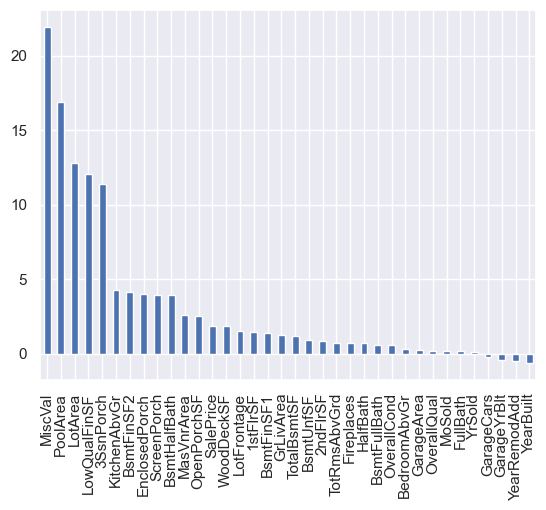

In [27]:
quantitative_df.skew().sort_values(ascending=False).plot.bar()

In [28]:
def high_positive_skew(df: pd.DataFrame) -> pd.DataFrame:
    return df.select_dtypes(include='number').loc[:,lambda df: df.skew().gt(.75)]

In [29]:
log1ptransform = partial(transform, func=np.log1p)

In [30]:
transformed_df = log1ptransform(quantitative_df, subset=high_positive_skew)

# Linear correlations

In [31]:
def r_pvalue(df: pd.DataFrame) -> pd.Series:
    """
    Wastefully calculates pearson's coefficient, by computing it with scipy.stats.pearsonr,
    possibly twice if you already used pd.DataFrame.corr method to get r, just to get its pvalue.
    What else can I say?
    """
    pvalue_ser = (
        df.corr(method=lambda a, b: stats.pearsonr(a, b).pvalue)
        .unstack()
    )
    return pvalue_ser

In [32]:
def correlate_long(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    Calculates pearson's coefficient for DataFrame and returns it in long format with a multiindex. 
    Keyword args are passed to pd.DataFrame.corr method.
    """
    res = (
        df
        .corr(**kwargs)
        .unstack()
        .to_frame(name='r')
        .assign(
            r2=lambda df: df.r.pow(2),
        )
        .loc[combinations(df.columns, 2)]
    )
    return res

In [33]:
corrdf = (
    transformed_df
    .pipe(correlate_long)
    .assign(pvalue=r_pvalue(quantitative_df))
    .query('pvalue <= .05')
)

In [34]:
(
    corrdf.sort_values('r2', ascending=False)
    .head(20)
    .style.format(precision=4)
)

In [35]:
(
    corrdf.loc[(slice(None), 'SalePrice'),:]
    .sort_values('r2', ascending=False)
    .style.format(precision=4)
)

# Data distribution and relationships

## Quantitative

### Distribution

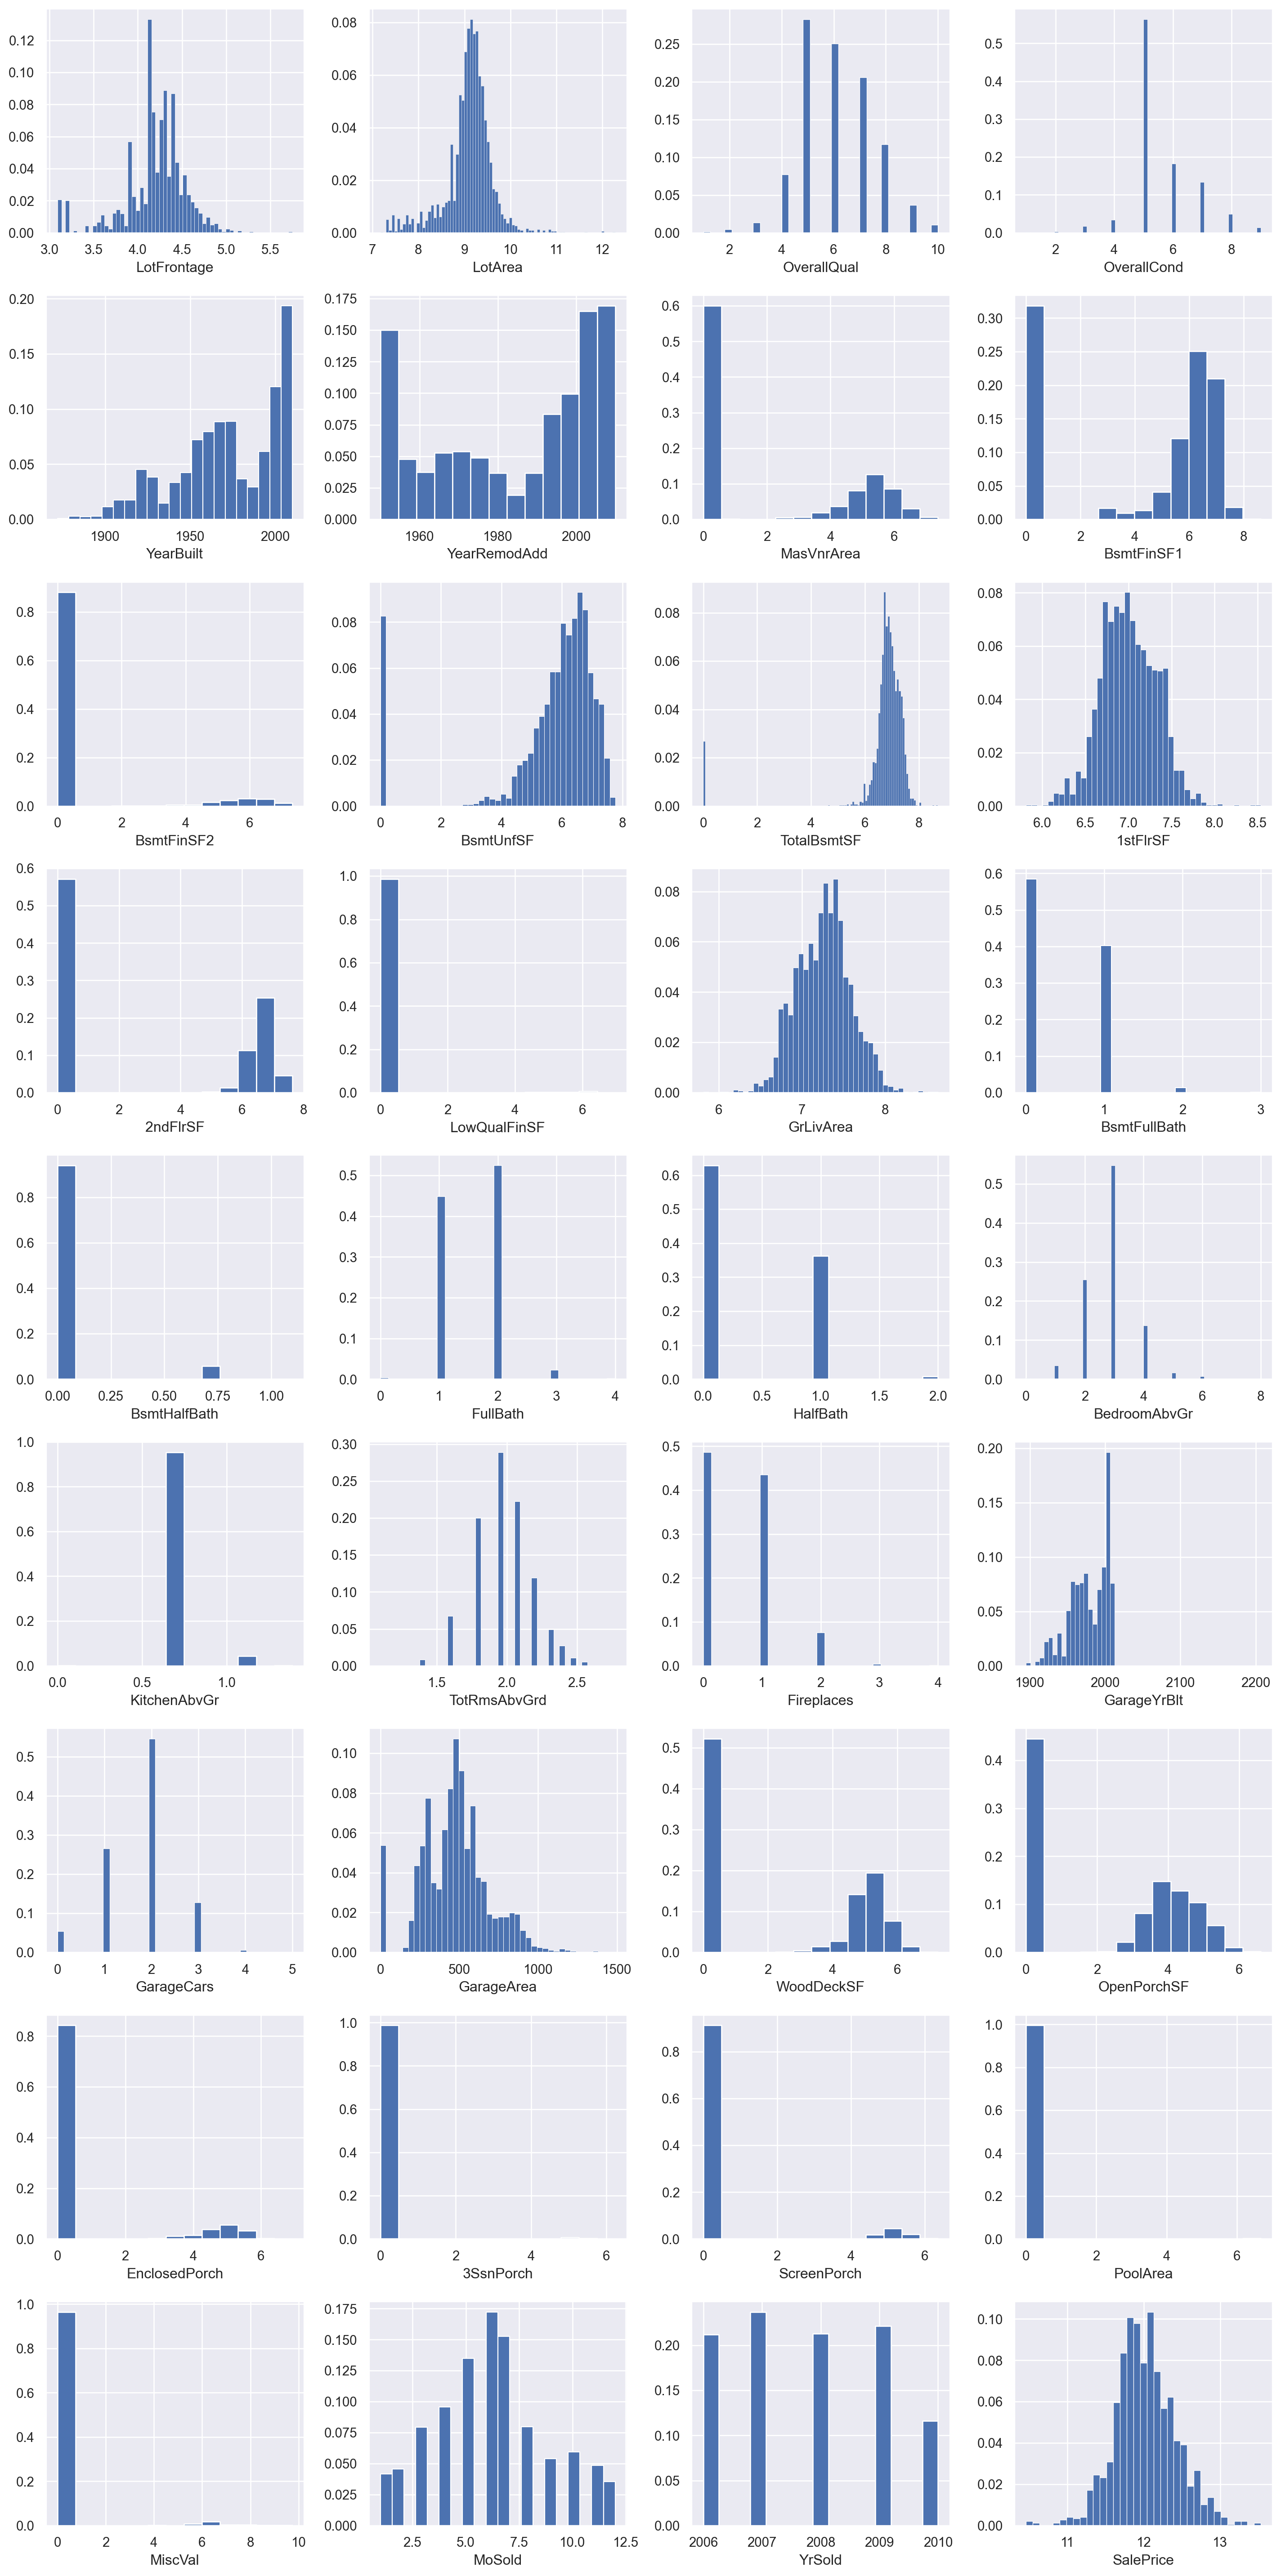

In [36]:
(
    so.Plot(transformed_df)
    .pair(x=transformed_df.columns, wrap=4)
    .add(so.Bars(alpha=1), so.Hist(stat='proportion', common_norm=False, common_bins=False))
    .share(x=False, y=False)
    .layout(size=(15, 30))
)

### Direct relationships with SalePrice

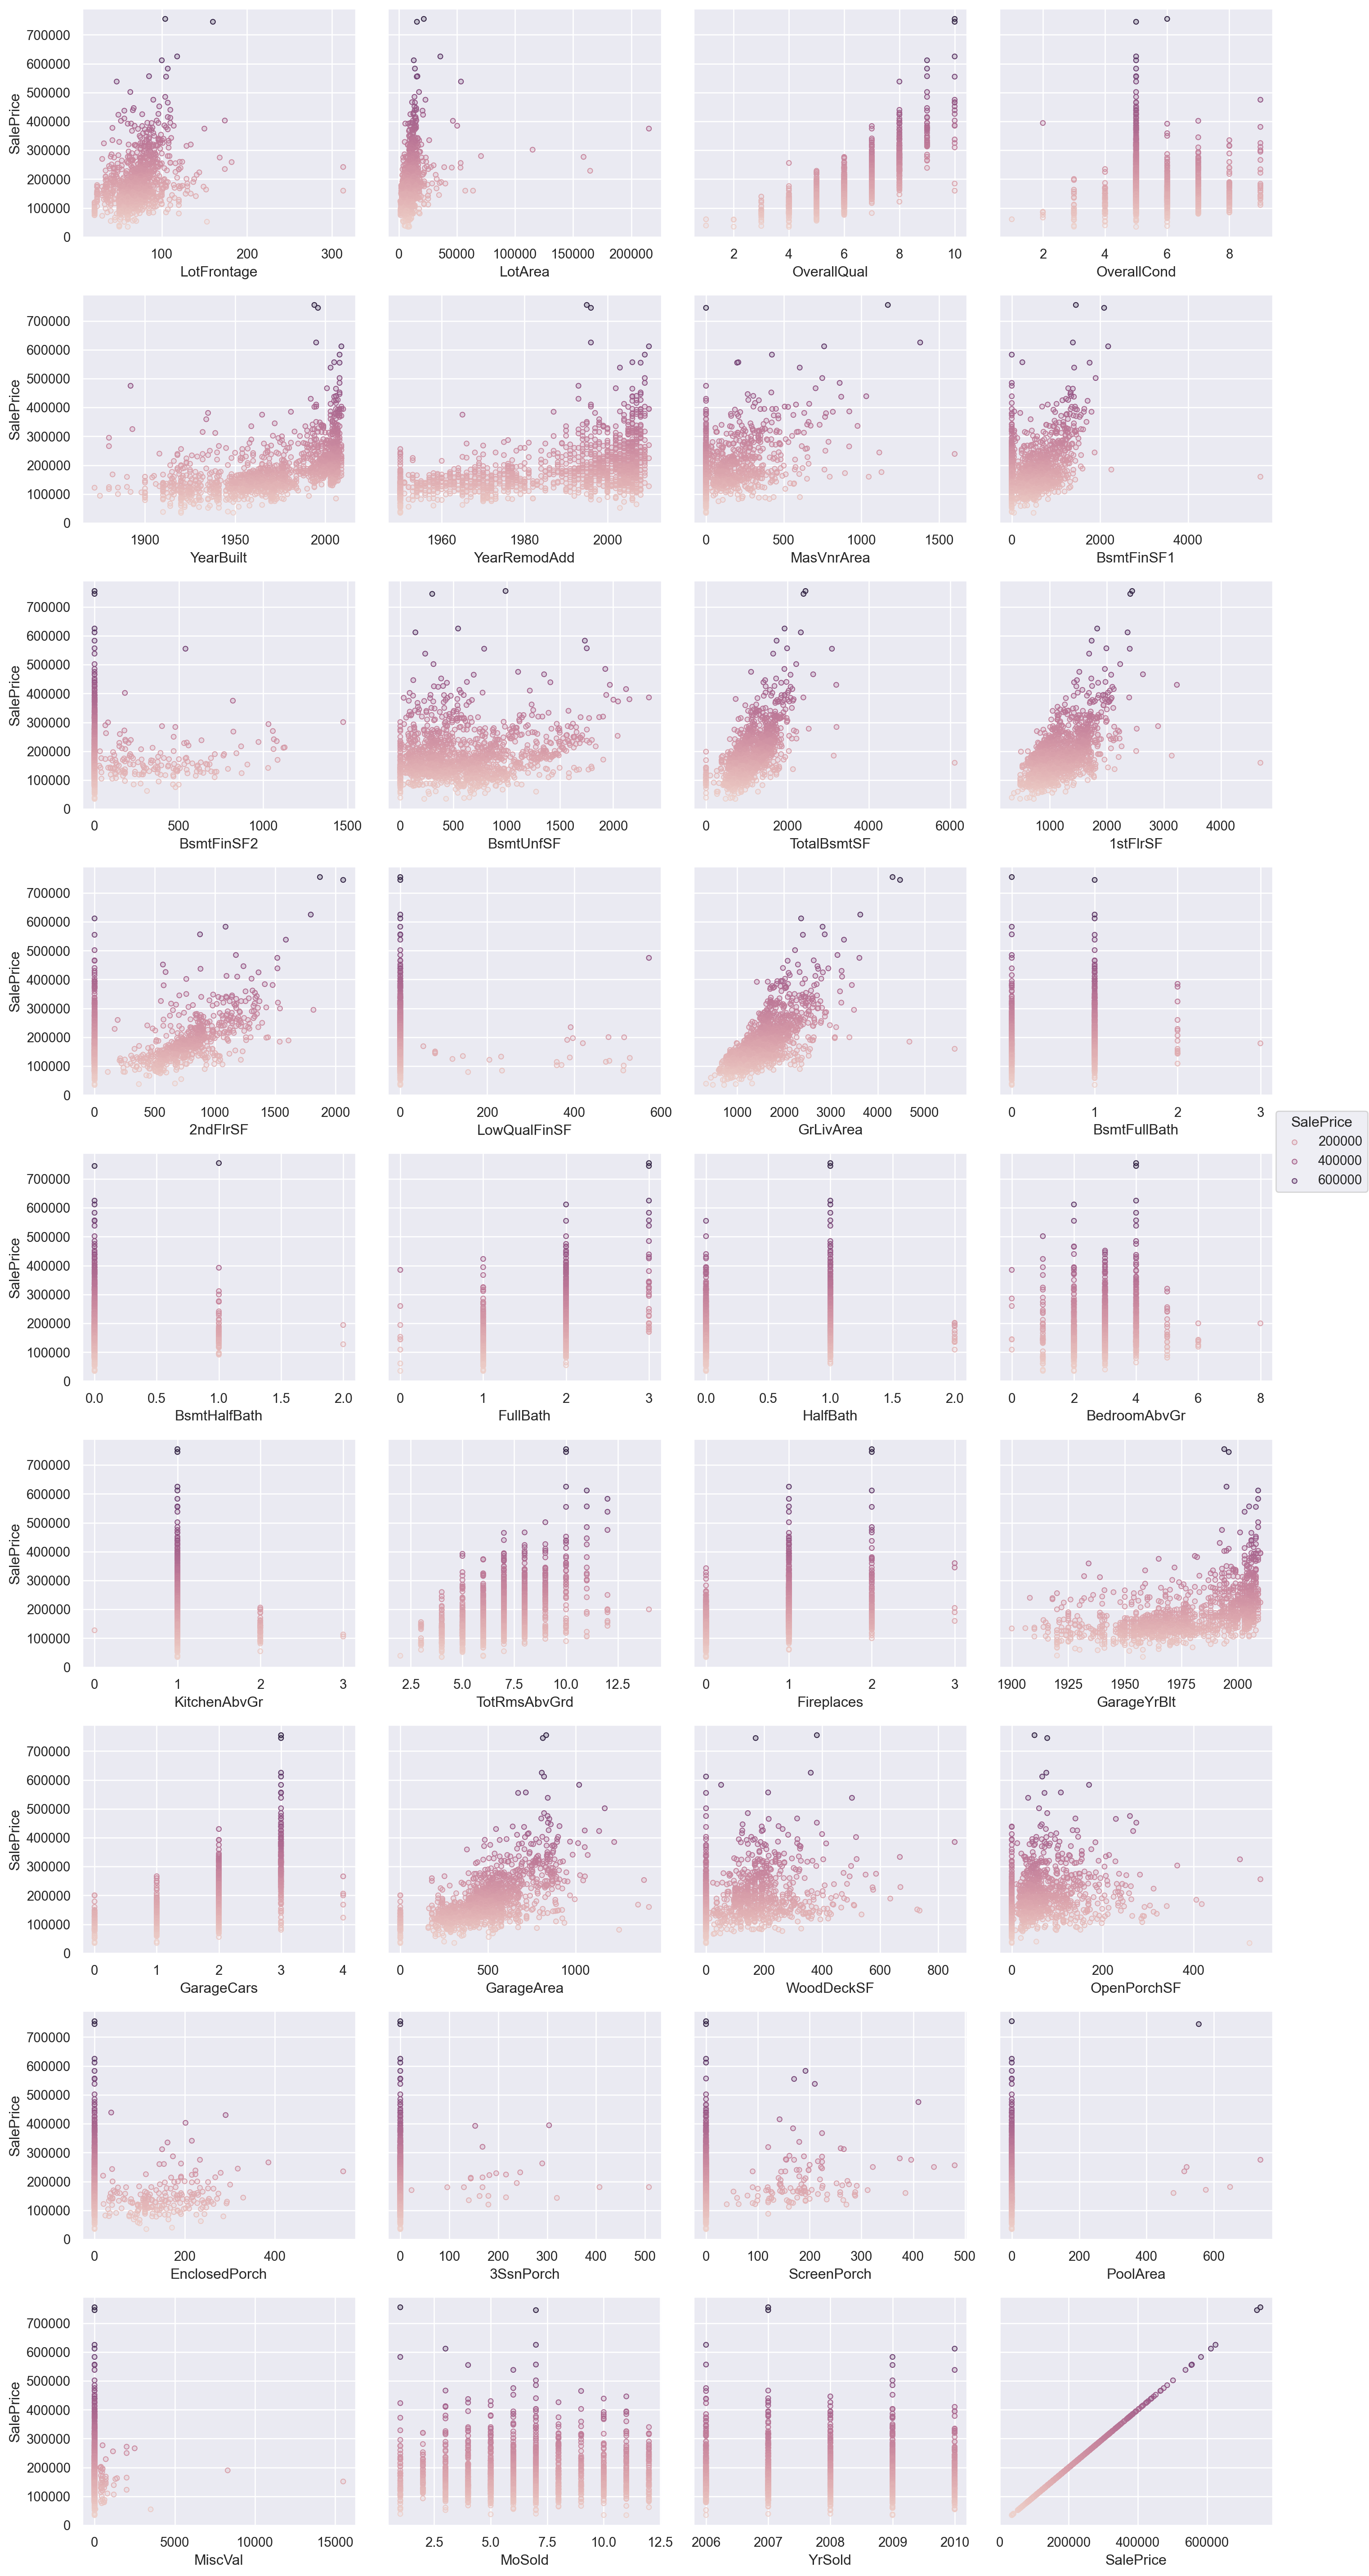

In [37]:
(
    so.Plot(train_df.select_dtypes('number'), y='SalePrice')
    .pair(x=train_df.select_dtypes('number').columns, wrap=4)
    .add(so.Dots(), color='SalePrice')
    .layout(size=(15, 30))
)

### Relations between predictors

In [38]:
corrdf.loc[(slice(None),'SalePrice'),:].sort_values('r2', ascending=False).head(10)

r        r2         pvalue
OverallQual  SalePrice  0.817185  0.667791  2.185675e-313
GrLivArea    SalePrice  0.730254  0.533271  4.518034e-223
GarageCars   SalePrice  0.680625  0.463250  2.498644e-169
GarageArea   SalePrice  0.650888  0.423655  5.265038e-158
1stFlrSF     SalePrice  0.608955  0.370826  5.394711e-147
FullBath     SalePrice  0.594771  0.353752  1.236470e-121
YearBuilt    SalePrice  0.586570  0.344065  2.990229e-103
YearRemodAdd SalePrice  0.565608  0.319912   3.164948e-96
GarageYrBlt  SalePrice  0.541073  0.292760   8.705128e-83
TotRmsAbvGrd SalePrice  0.539998  0.291598  2.772281e-108

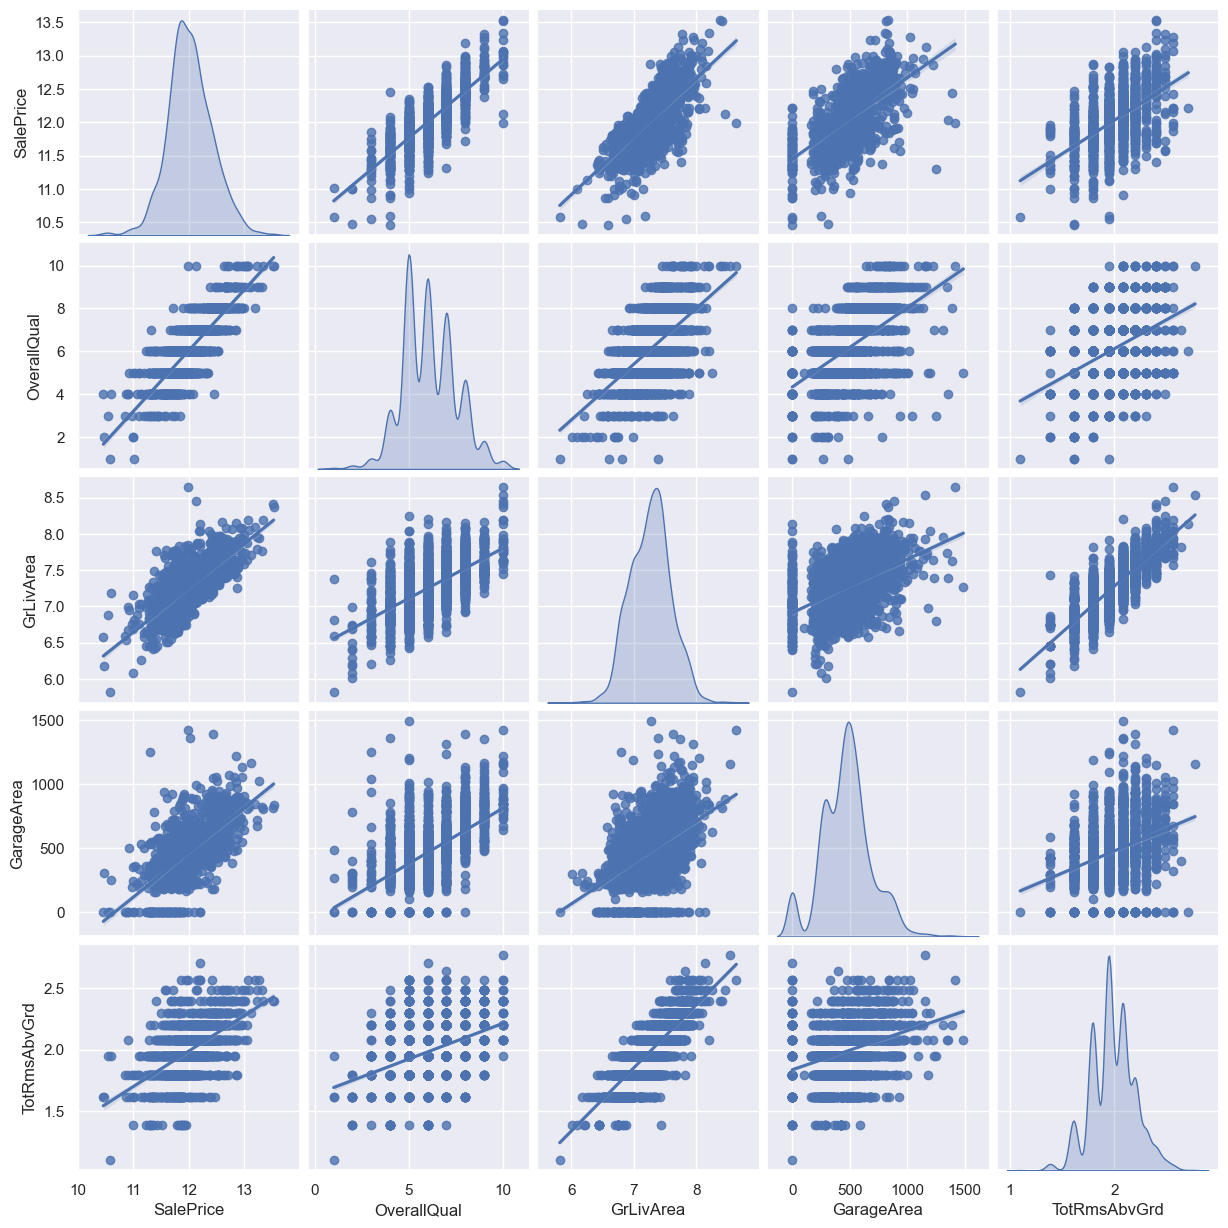

In [39]:
top_corr = transformed_df[['SalePrice','OverallQual','GrLivArea','GarageArea','TotRmsAbvGrd']]
sns.pairplot(top_corr, kind = 'reg', diag_kind = 'kde') 

## Categorical

In [40]:
qualitative_df = merged_df.select_dtypes(exclude='number').astype({'MSSubClass': 'int'})

### Boxplots

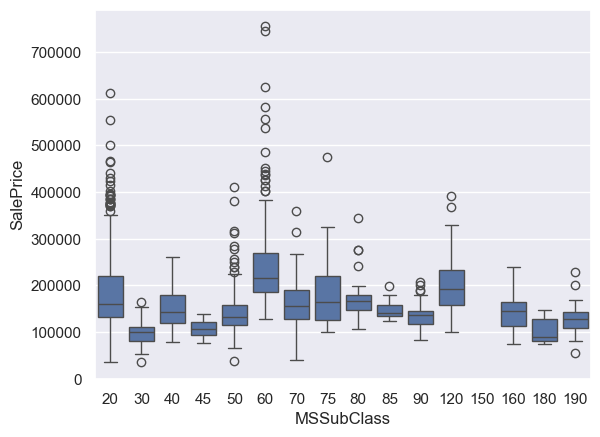

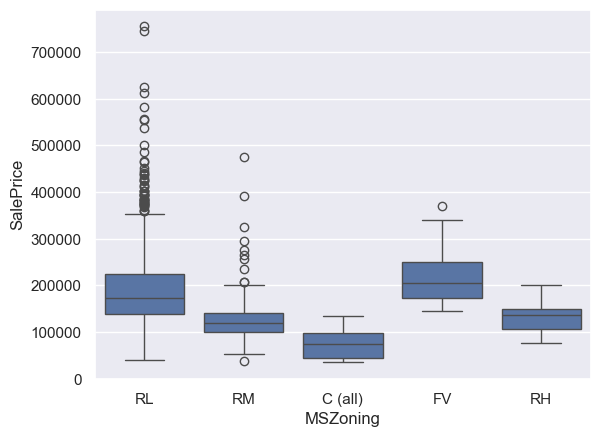

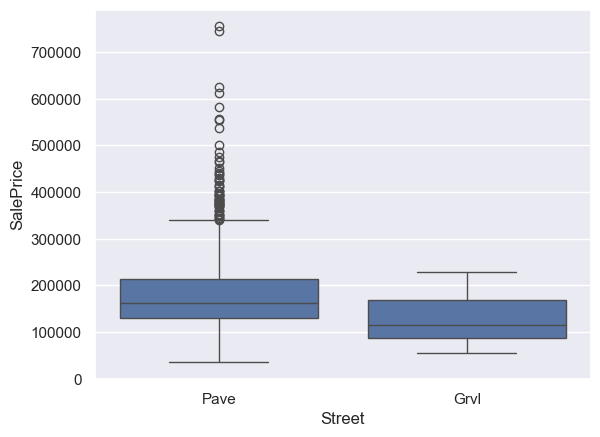

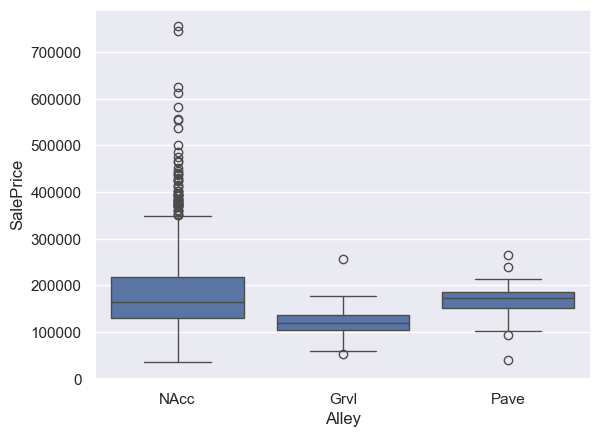

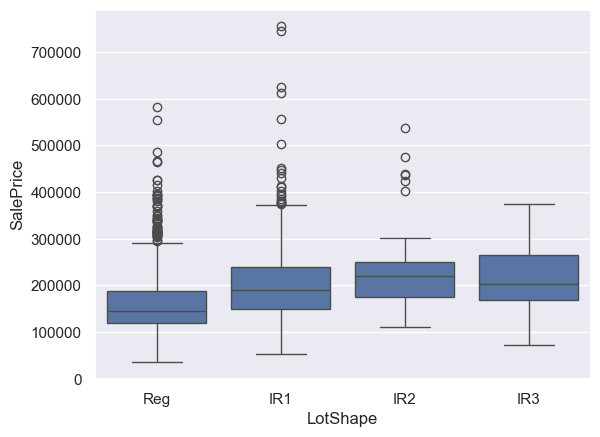

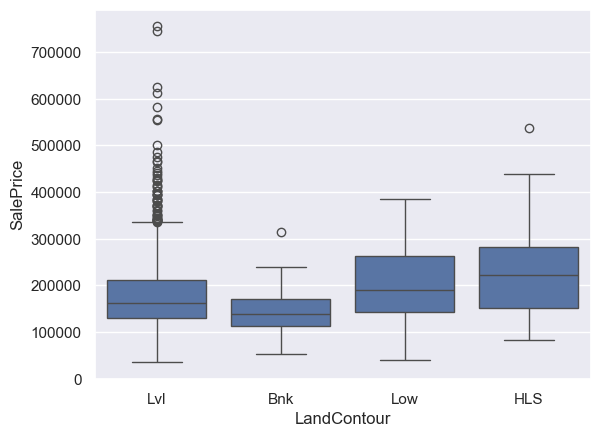

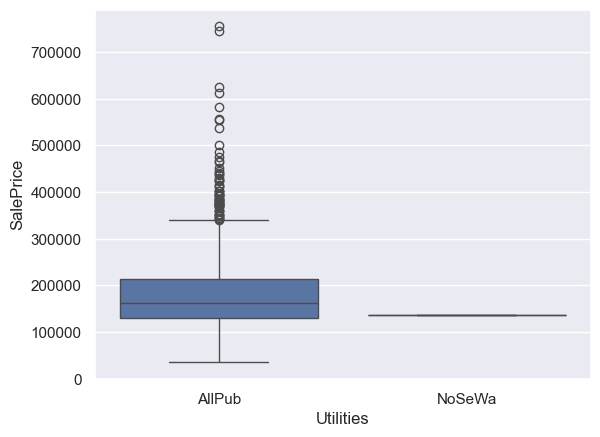

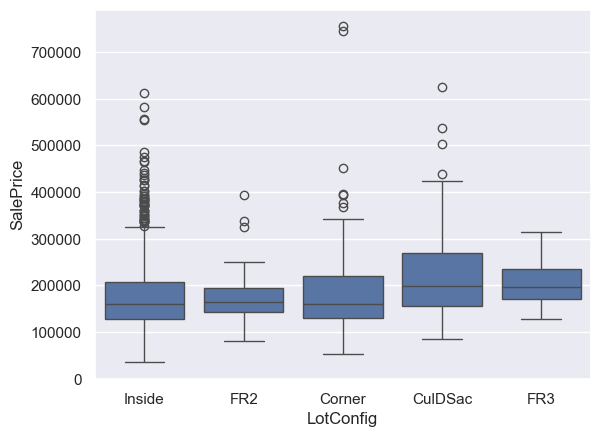

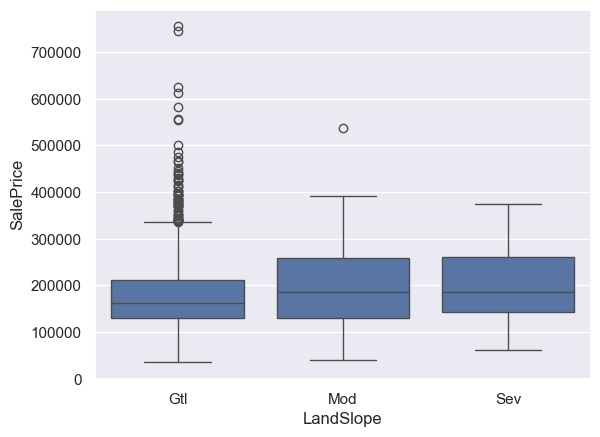

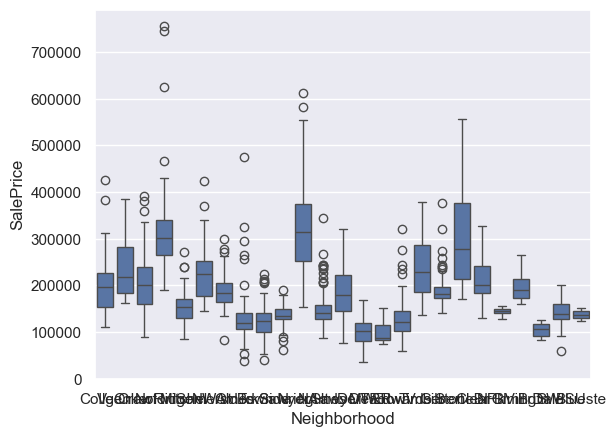

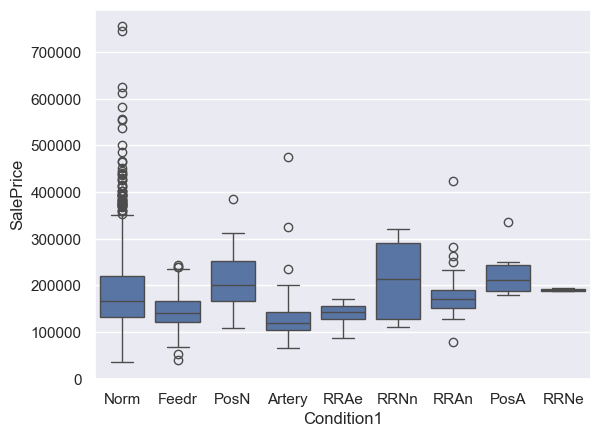

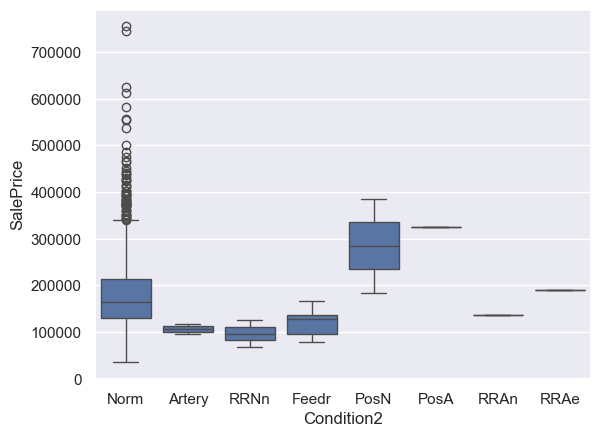

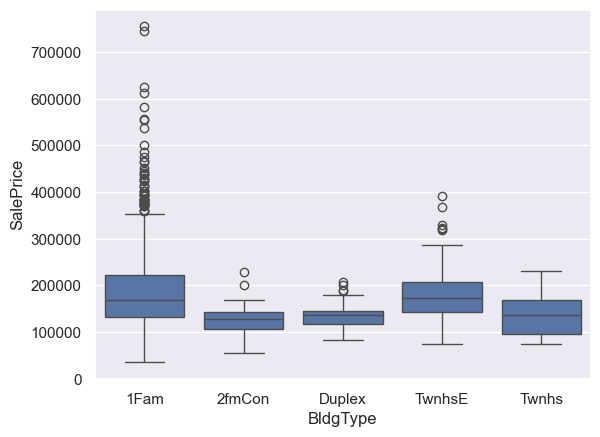

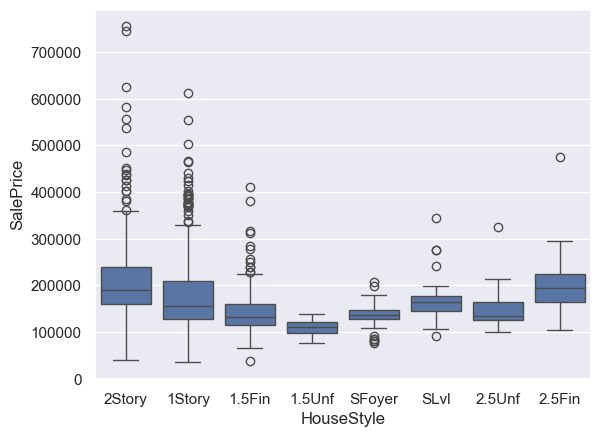

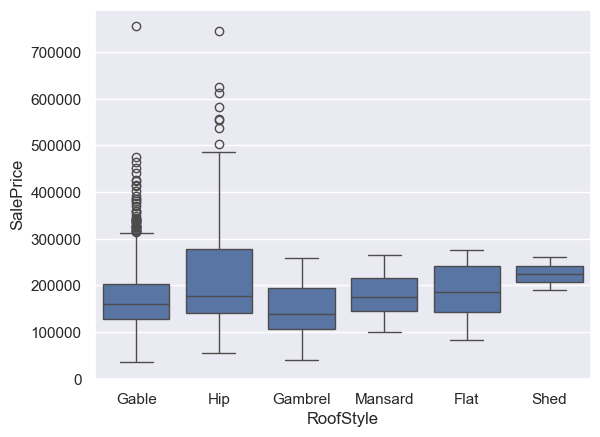

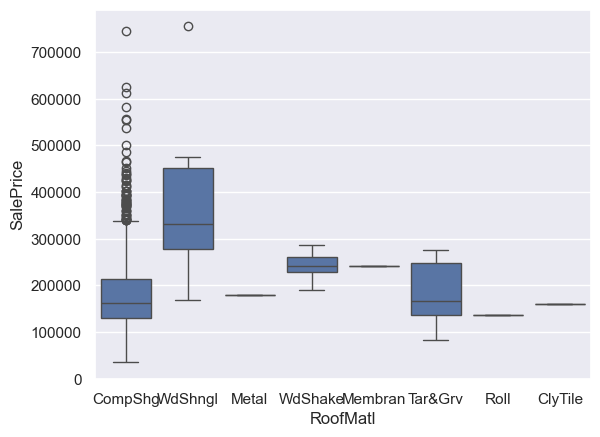

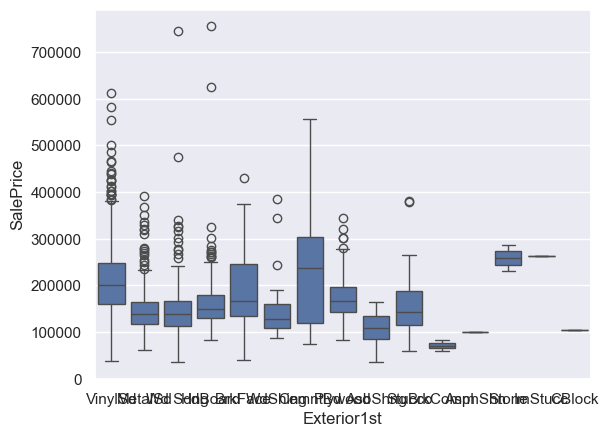

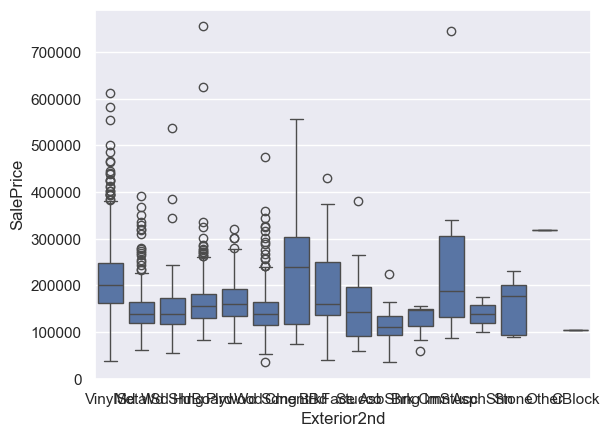

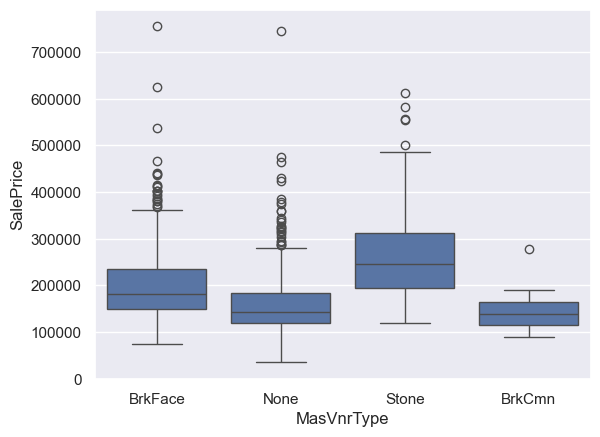

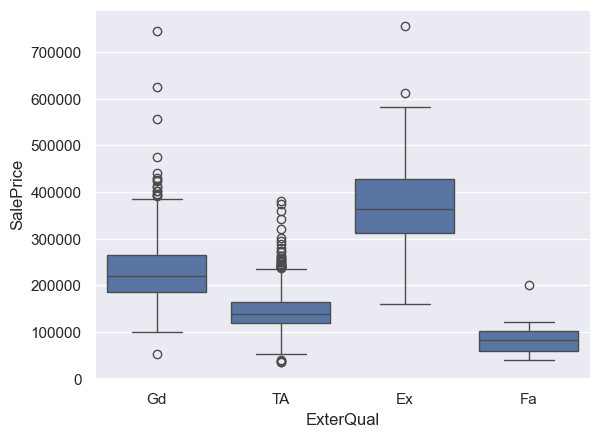

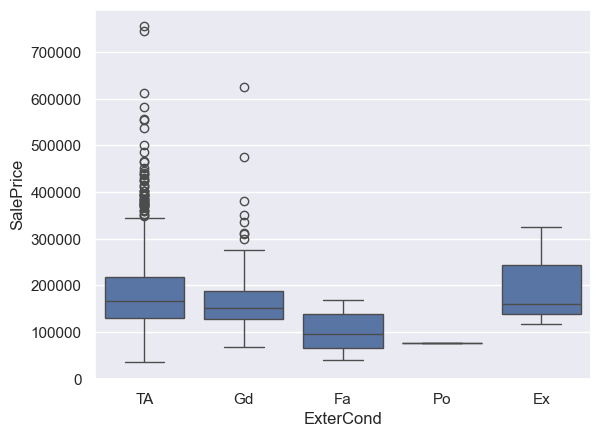

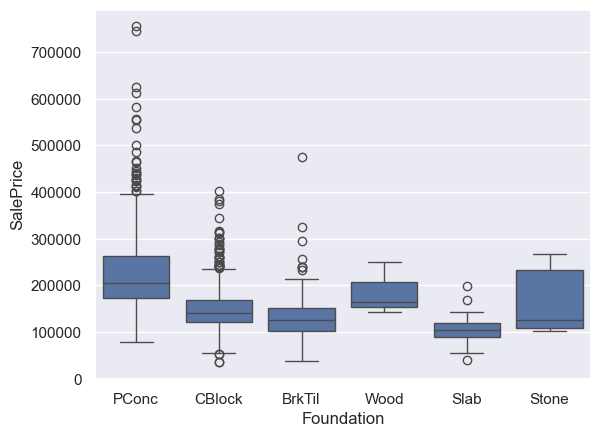

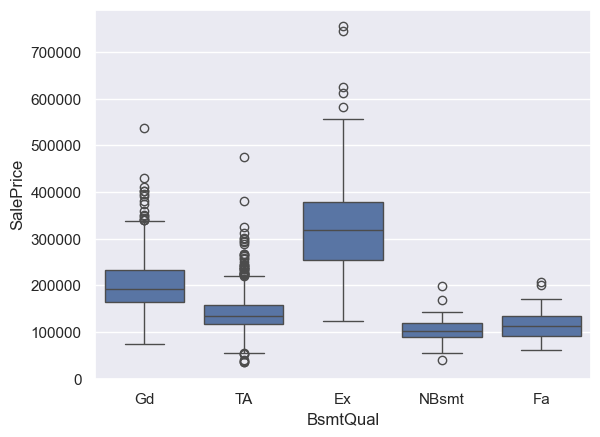

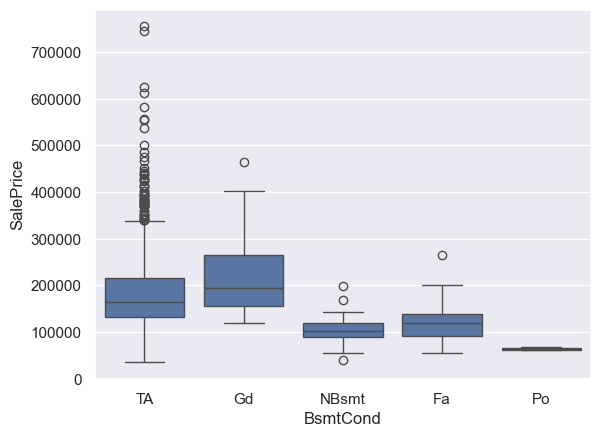

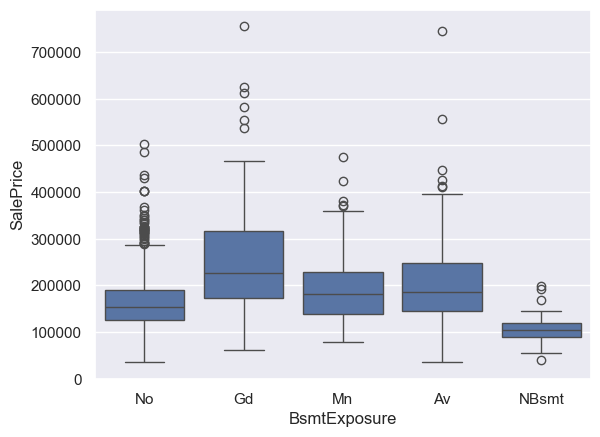

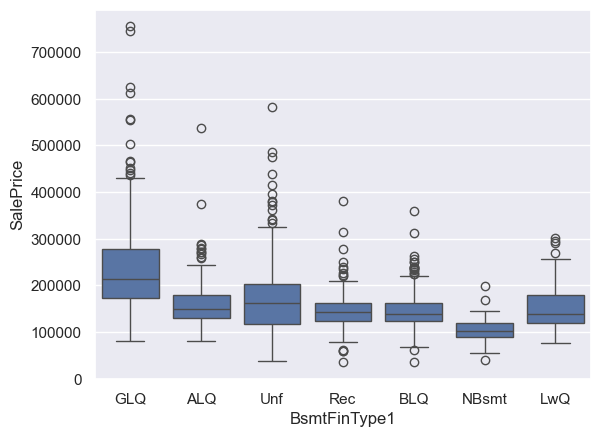

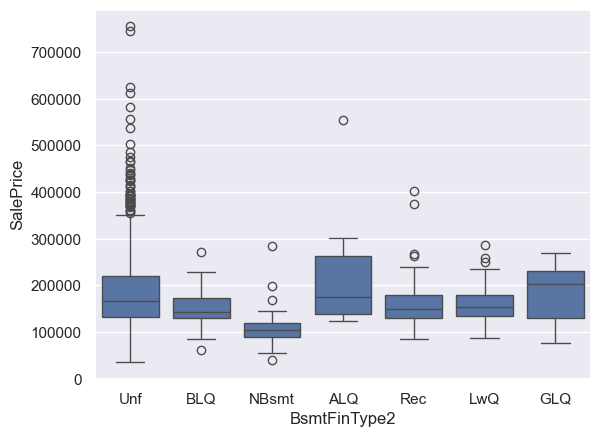

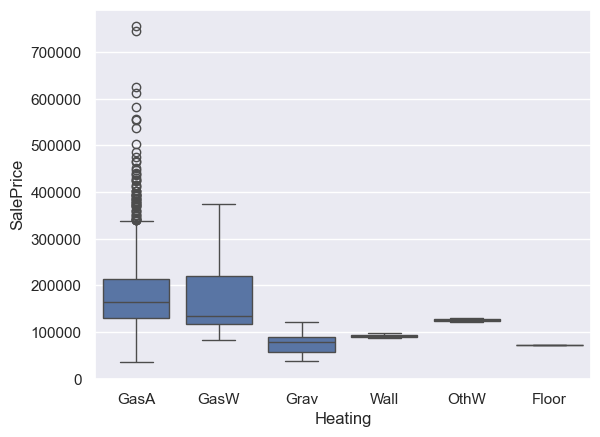

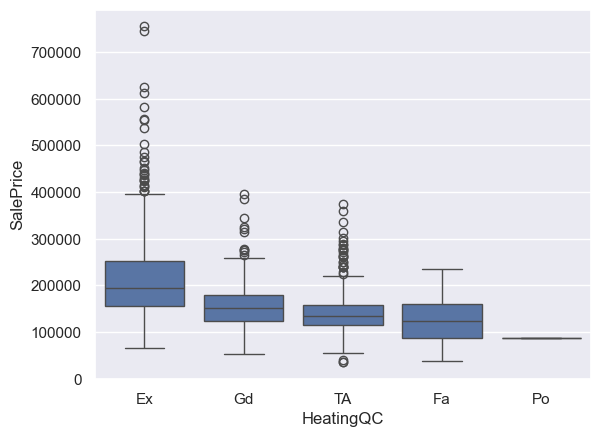

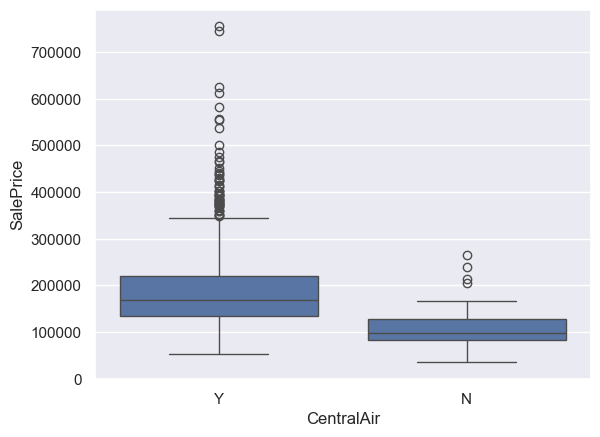

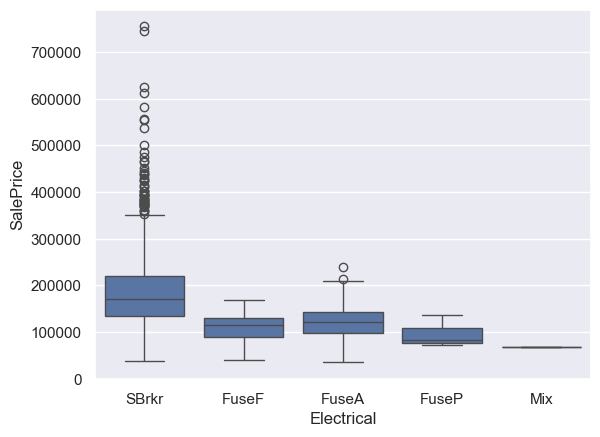

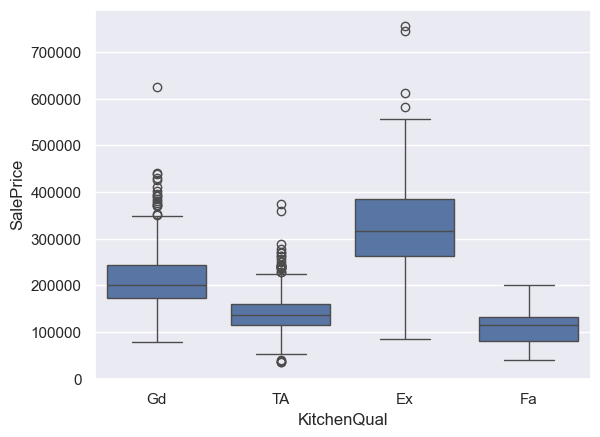

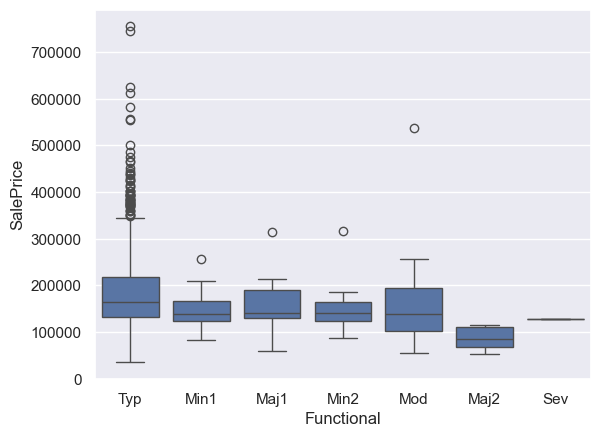

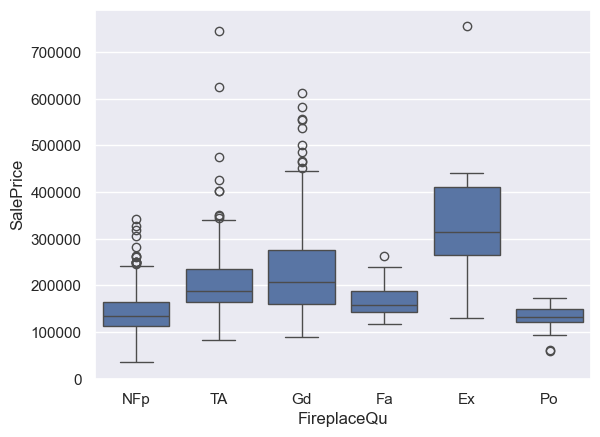

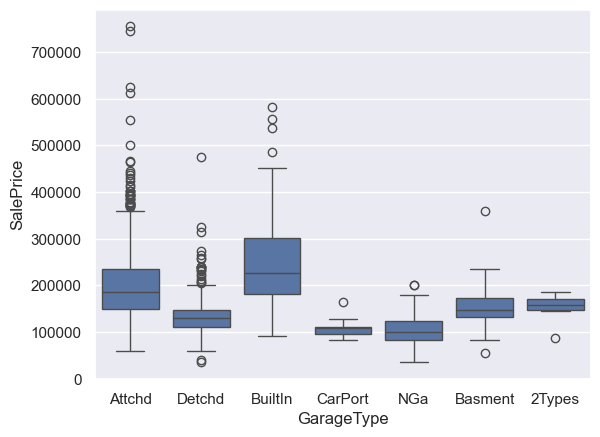

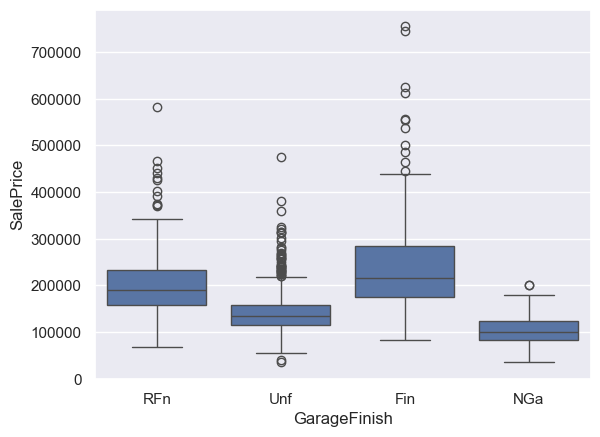

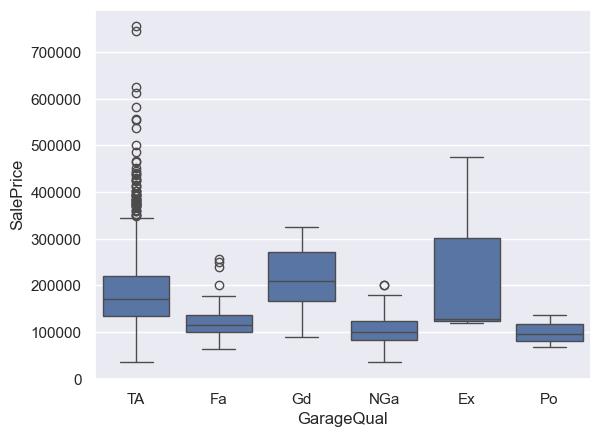

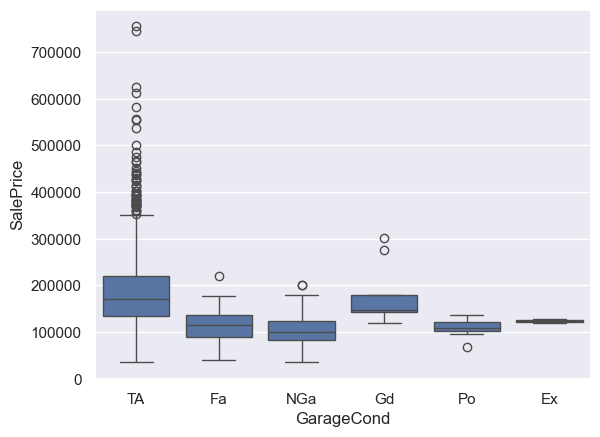

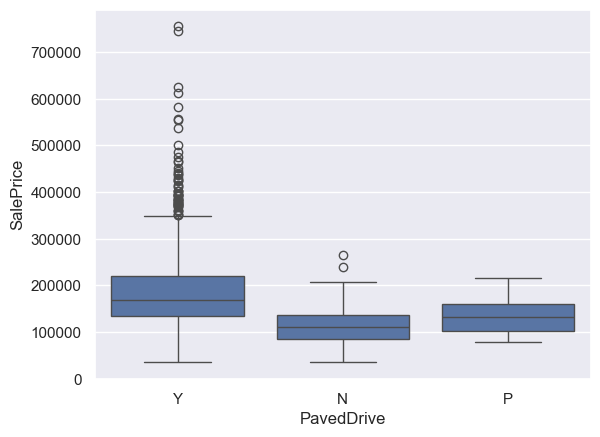

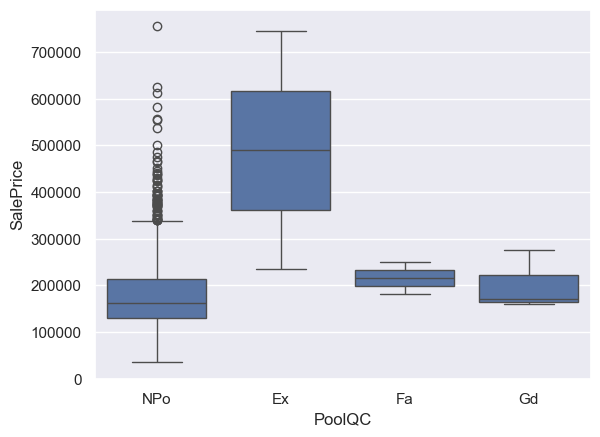

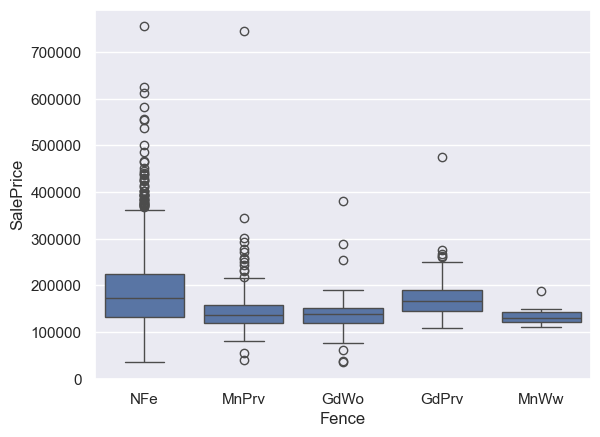

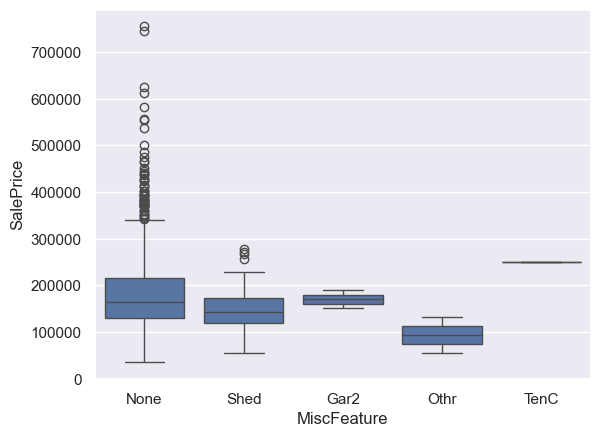

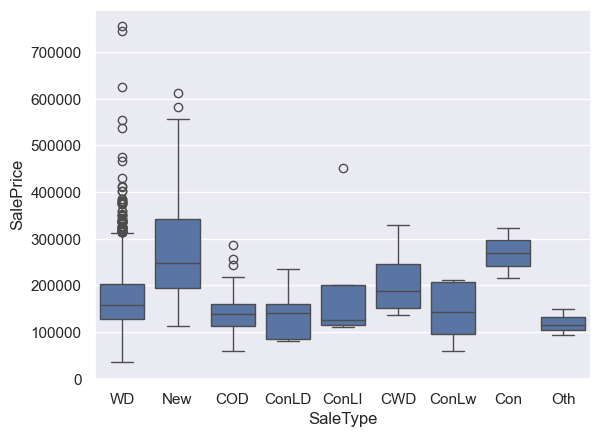

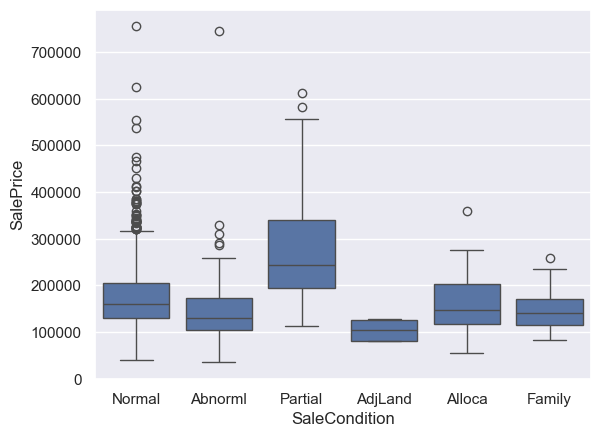

In [41]:
for col in qualitative_df.columns:
    sns.boxplot(data=qualitative_df, x=col, y=train_df.SalePrice)
    plt.show()

# Dealing with missing values

## Setup

We define several functions to make it a breeze to impute data.

In [42]:
def filternacols(df: pd.DataFrame) -> pd.DataFrame:
    return df.loc[:, df.isna().any()]

In [43]:
def fillna(ser: pd.Series, f: Callable[pd.Series, ...], *args, **kwargs) -> pd.Series:
    """
    Fills nan in pd.Series with result of `f`. Positional and keyword arguments are passed to `f`.
    """
    filling = f(ser, *args, **kwargs)
    if isinstance(filling, pd.Series) and filling.size == 1:
        filling = filling.iloc[0]
    return ser.fillna(filling)

In [44]:
# to be used with impute_* functions
with_mean = partial(fillna, f=pd.Series.mean)
with_mode = partial(fillna, f=pd.Series.mode)
with_median = partial(fillna, f=pd.Series.median)
# to be use inside assign. literally an alias so that code is more readable
fillna_with_mean = partial(fillna, f=pd.Series.mean)
fillna_with_mode = partial(fillna, f=pd.Series.mode)
fillna_with_median = partial(fillna, f=pd.Series.median)

In [45]:
@starassign
def label_encode(
    df: pd.DataFrame, 
    encoder: Callable[[pd.Series, ...], Iterable[int]] = LabelEncoder().fit_transform,
    subset: Callable[[pd.DataFrame], pd.DataFrame] = lambda df: df.select_dtypes(exclude='number'),
    *args, **kwargs) -> pd.DataFrame:
    """
    Encodes each column of the pd.DataFrame returned by `subset`. 
    `subset` is piped into `df`.
    Positional and keyword arguments are passed to `encoder`.
    Beware that default label encoder treats nan as another label. 
    """
    return df.pipe(subset).transform(encoder, *args, **kwargs)

In [46]:
@starassign
def impute_subset(
    df: pd.DataFrame,
    fillmethod: Callable[[pd.Series, ...], pd.Series],
    subset: Callable[[pd.DataFrame], pd.DataFrame | pd.Series | pd.core.groupby.GroupBy],
    *args, **kwargs) -> pd.DataFrame:
    """
    Imputes `df` with subset of this dataframe that has had `fillmethod` applied to its columns.
    `subset` is piped into `df`.
    If `subset` contains columns that don't have any nan, they are returned as is.
    Positional and keyword arguments are passed to `fillmethod`.
    """
    return df.pipe(subset).apply(fillmethod, *args, **kwargs)

In [47]:
categorical = lambda df: df.select_dtypes(exclude='number')
numerical = lambda df: df.select_dtypes(include='number')

In [48]:
impute_numerical = partial(
    impute_subset, 
    subset=lambda df: df.select_dtypes(include='number').pipe(filternacols),
)
impute_categorical = partial(
    impute_subset,
    subset=lambda df: df.select_dtypes(exclude='number').pipe(filternacols),
)

In [49]:
def groupby(
    by: Iterable[IndexLabel] | IndexLabel, 
    on: Iterable[IndexLabel] | IndexLabel,
    group_keys: bool = False, 
    *args, **kwargs) -> Callable[pd.DataFrame, pd.core.groupby.GroupBy]:
    """
    Higher-order function to create groupbys for `impute_*` functions based on `by` and `on`.
    Positional and keyword arguments are passed `df`.groupby.
    """
    def grouper(df: pd.DataFrame) -> pd.core.groupby.GroupBy:
        return df.groupby(by=by, group_keys=group_keys, *args, **kwargs)[on]
    return grouper

In [50]:
def impute_groupby(
    df: pd.DataFrame, 
    fillmethod: Callable[pd.Series, pd.Series], 
    by: Iterable[IndexLabel] | IndexLabel,
    on: Iterable[IndexLabel] | IndexLabel, 
    *args, **kwargs) -> pd.DataFrame:
    """
    Convenience function to impute `df` on columns `on` on groups `by`, with `fillmethod`.
    If group doesn't have any nan, they are returned as is.
    Positional and keyword arguments are passed to `fillmethod`.
    """
    grouper = groupby(by=by, on=on)
    return impute_subset(df, fillmethod, grouper, *args, **kwargs)

In [51]:
train_nancnt_df

nancnt  dtypes_
LotFrontage     259  float64
GarageYrBlt      81  float64
MasVnrArea        8  float64
Electrical        1   object

In [52]:
test_nancnt_df

nancnt  dtypes_
LotFrontage      227  float64
GarageYrBlt       78  float64
MasVnrArea        15  float64
MSZoning           4   object
BsmtFullBath       2  float64
BsmtHalfBath       2  float64
Utilities          2   object
Functional         2   object
GarageArea         1  float64
TotalBsmtSF        1  float64
BsmtUnfSF          1  float64
BsmtFinSF2         1  float64
BsmtFinSF1         1  float64
KitchenQual        1   object
Exterior2nd        1   object
GarageCars         1  float64
Exterior1st        1   object
SaleType           1   object

## MSZoning

Naive approach

<Axes: xlabel='MSZoning', ylabel='SalePrice'>

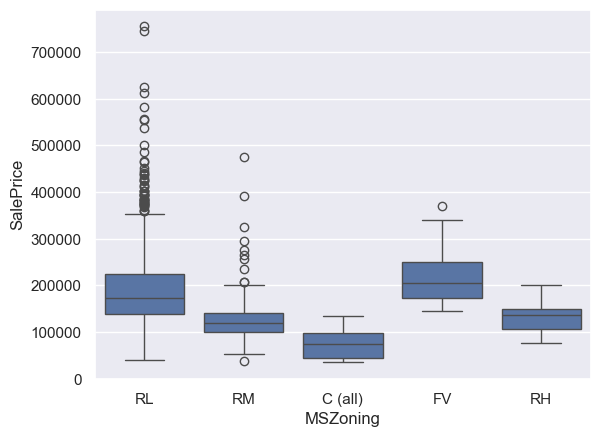

In [53]:
sns.boxplot(data=merged_df, x='MSZoning', y='SalePrice')

In [54]:
(
    merged_df.pipe(log1ptransform, subset=high_positive_skew)
    .pipe(label_encode)
    .pipe(correlate_long)
    .loc['MSZoning',lambda df: ~df.columns.isin(['MSZoning'])]
    .sort_values('r2', ascending=False)
    .head(5)
)

r        r2
Alley        -0.375400  0.140925
YearBuilt    -0.315786  0.099721
GarageYrBlt  -0.291742  0.085113
Foundation   -0.266138  0.070829
Neighborhood -0.261544  0.068405

In [55]:
pd.crosstab(*merged_df.loc[:,['Alley','MSZoning']].T.to_numpy())

col_0  C (all)  FV  RH    RL   RM
row_0                            
Grvl         1   0   0    30   89
NAcc        22  87  22  2225  361
Pave         2  52   4    10   10

<Axes: xlabel='MSZoning', ylabel='YearBuilt'>

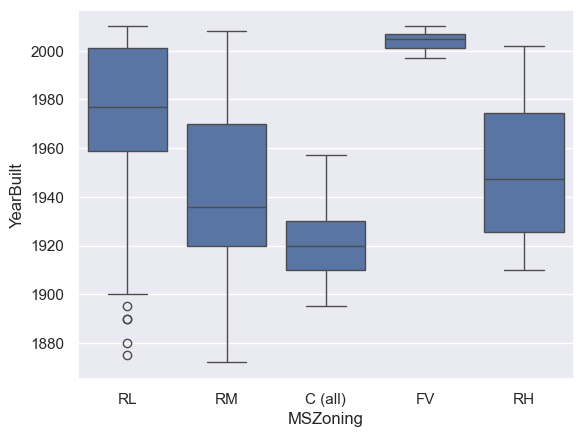

In [56]:
sns.boxplot(data=merged_df, x='MSZoning', y='YearBuilt')

## MasVnrArea

<Axes: xlabel='MasVnrType', ylabel='MasVnrArea'>

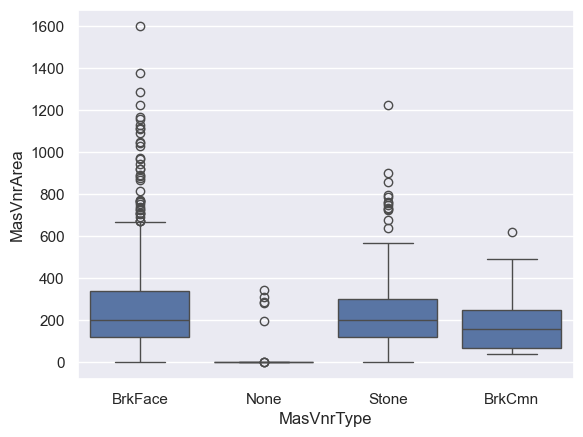

In [57]:
sns.boxplot(data=merged_df, x='MasVnrType', y='MasVnrArea')

## BsmtBaths

This won't really affect the results, leaving here for reference and later feature engineering. Median of BsmtBaths is 0 anyway.

In [58]:
plot_data = merged_df.assign(BsmtBaths=lambda df: df.BsmtFullBath+df.BsmtHalfBath)

In [59]:
plot_data.BsmtBaths.median()

0.0

In [60]:
plot_data.groupby('BsmtQual').BsmtBaths.median()

BsmtQual
Ex       1.0
Fa       0.0
Gd       1.0
NBsmt    0.0
TA       0.0
Name: BsmtBaths, dtype: float64

In [61]:
plot_data.groupby('BsmtCond').BsmtBaths.median()

BsmtCond
Fa       0.0
Gd       1.0
NBsmt    0.0
Po       0.0
TA       0.0
Name: BsmtBaths, dtype: float64

<Axes: xlabel='BsmtQual', ylabel='BsmtBaths'>

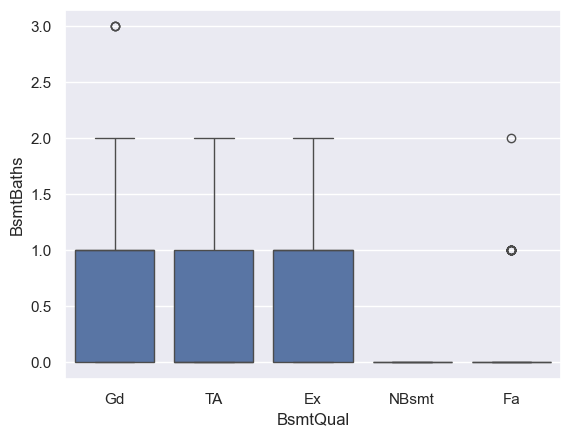

In [62]:
sns.boxplot(data=plot_data, x='BsmtQual', y='BsmtBaths')

<Axes: xlabel='BsmtCond', ylabel='BsmtBaths'>

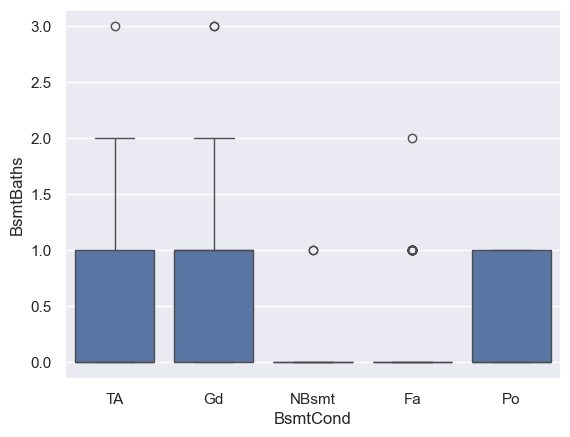

In [63]:
sns.boxplot(data=plot_data, x='BsmtCond', y='BsmtBaths')

## LotFrontage

Naive aproach

In [64]:
(
    merged_df.pipe(log1ptransform, subset=high_positive_skew)
    .pipe(label_encode)
    .pipe(correlate_long)
    .loc['LotFrontage',lambda df: ~df.columns.isin(['LotFrontage'])]
    .sort_values('r2', ascending=False)
    .head(10)
)

r        r2
LotArea       0.765301  0.585686
BldgType     -0.602179  0.362620
1stFlrSF      0.467969  0.218995
SalePrice     0.364650  0.132969
TotRmsAbvGrd  0.355734  0.126546
GarageArea    0.337097  0.113634
GrLivArea     0.330341  0.109125
GarageCars    0.292836  0.085753
GarageType   -0.287664  0.082751
BedroomAbvGr  0.257851  0.066487

<Axes: xlabel='BldgType', ylabel='LotFrontage'>

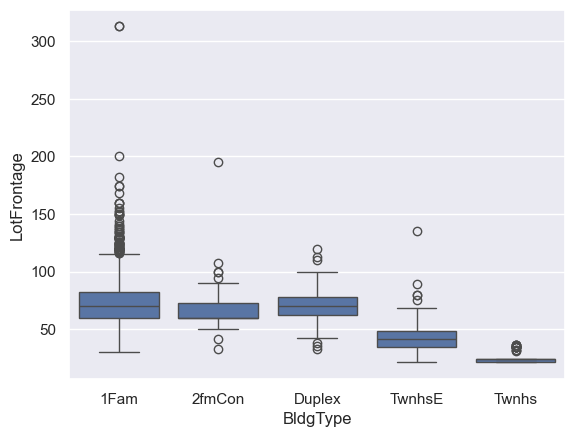

In [65]:
sns.boxplot(merged_df, x='BldgType', y='LotFrontage')

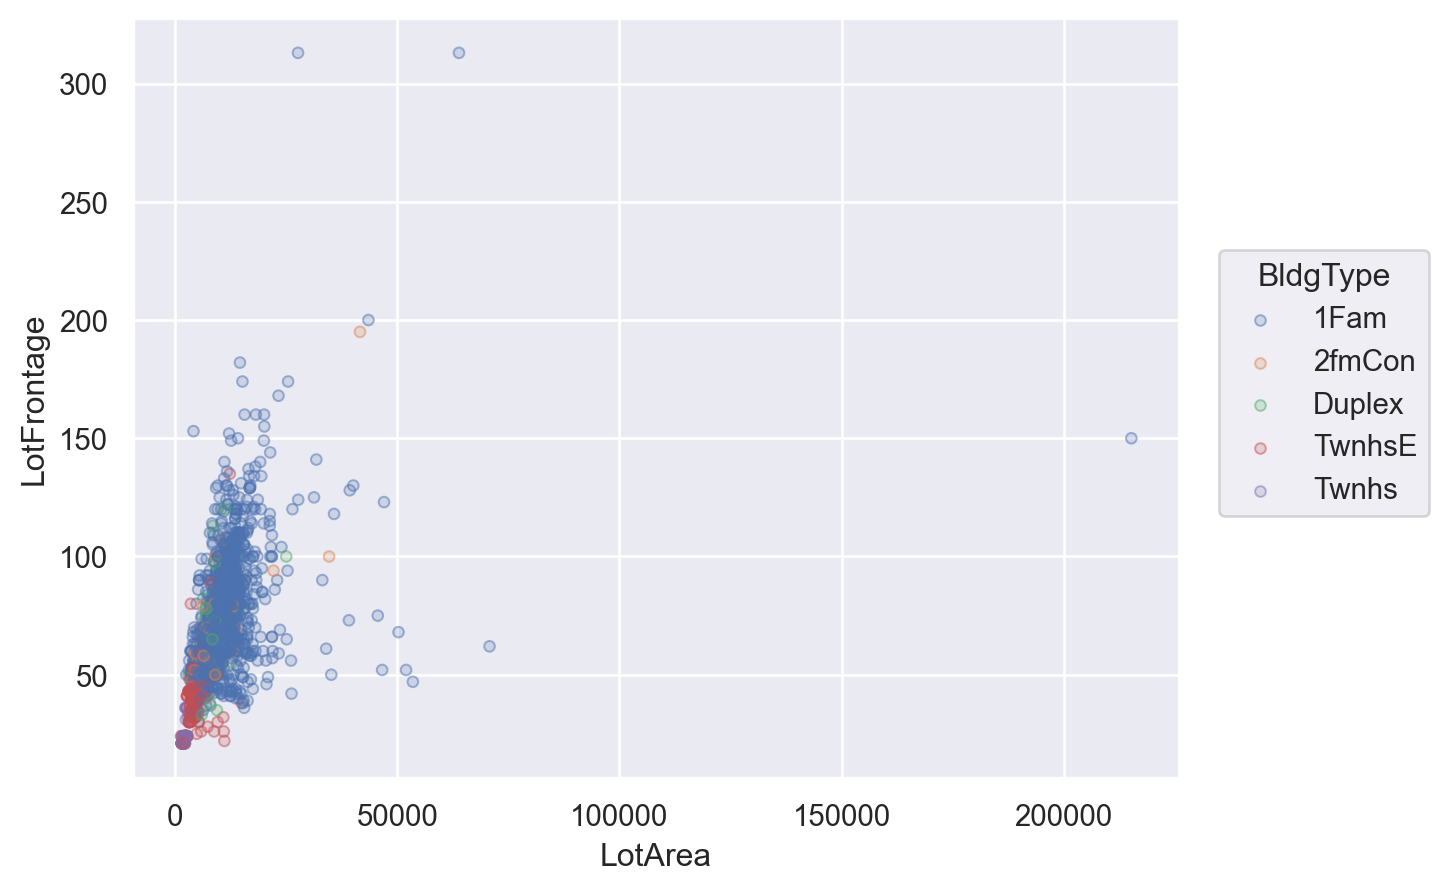

In [66]:
(
    so.Plot(
        merged_df, 
        x='LotArea', y='LotFrontage'
    )
    .add(so.Dots(alpha=.5), color='BldgType')
)

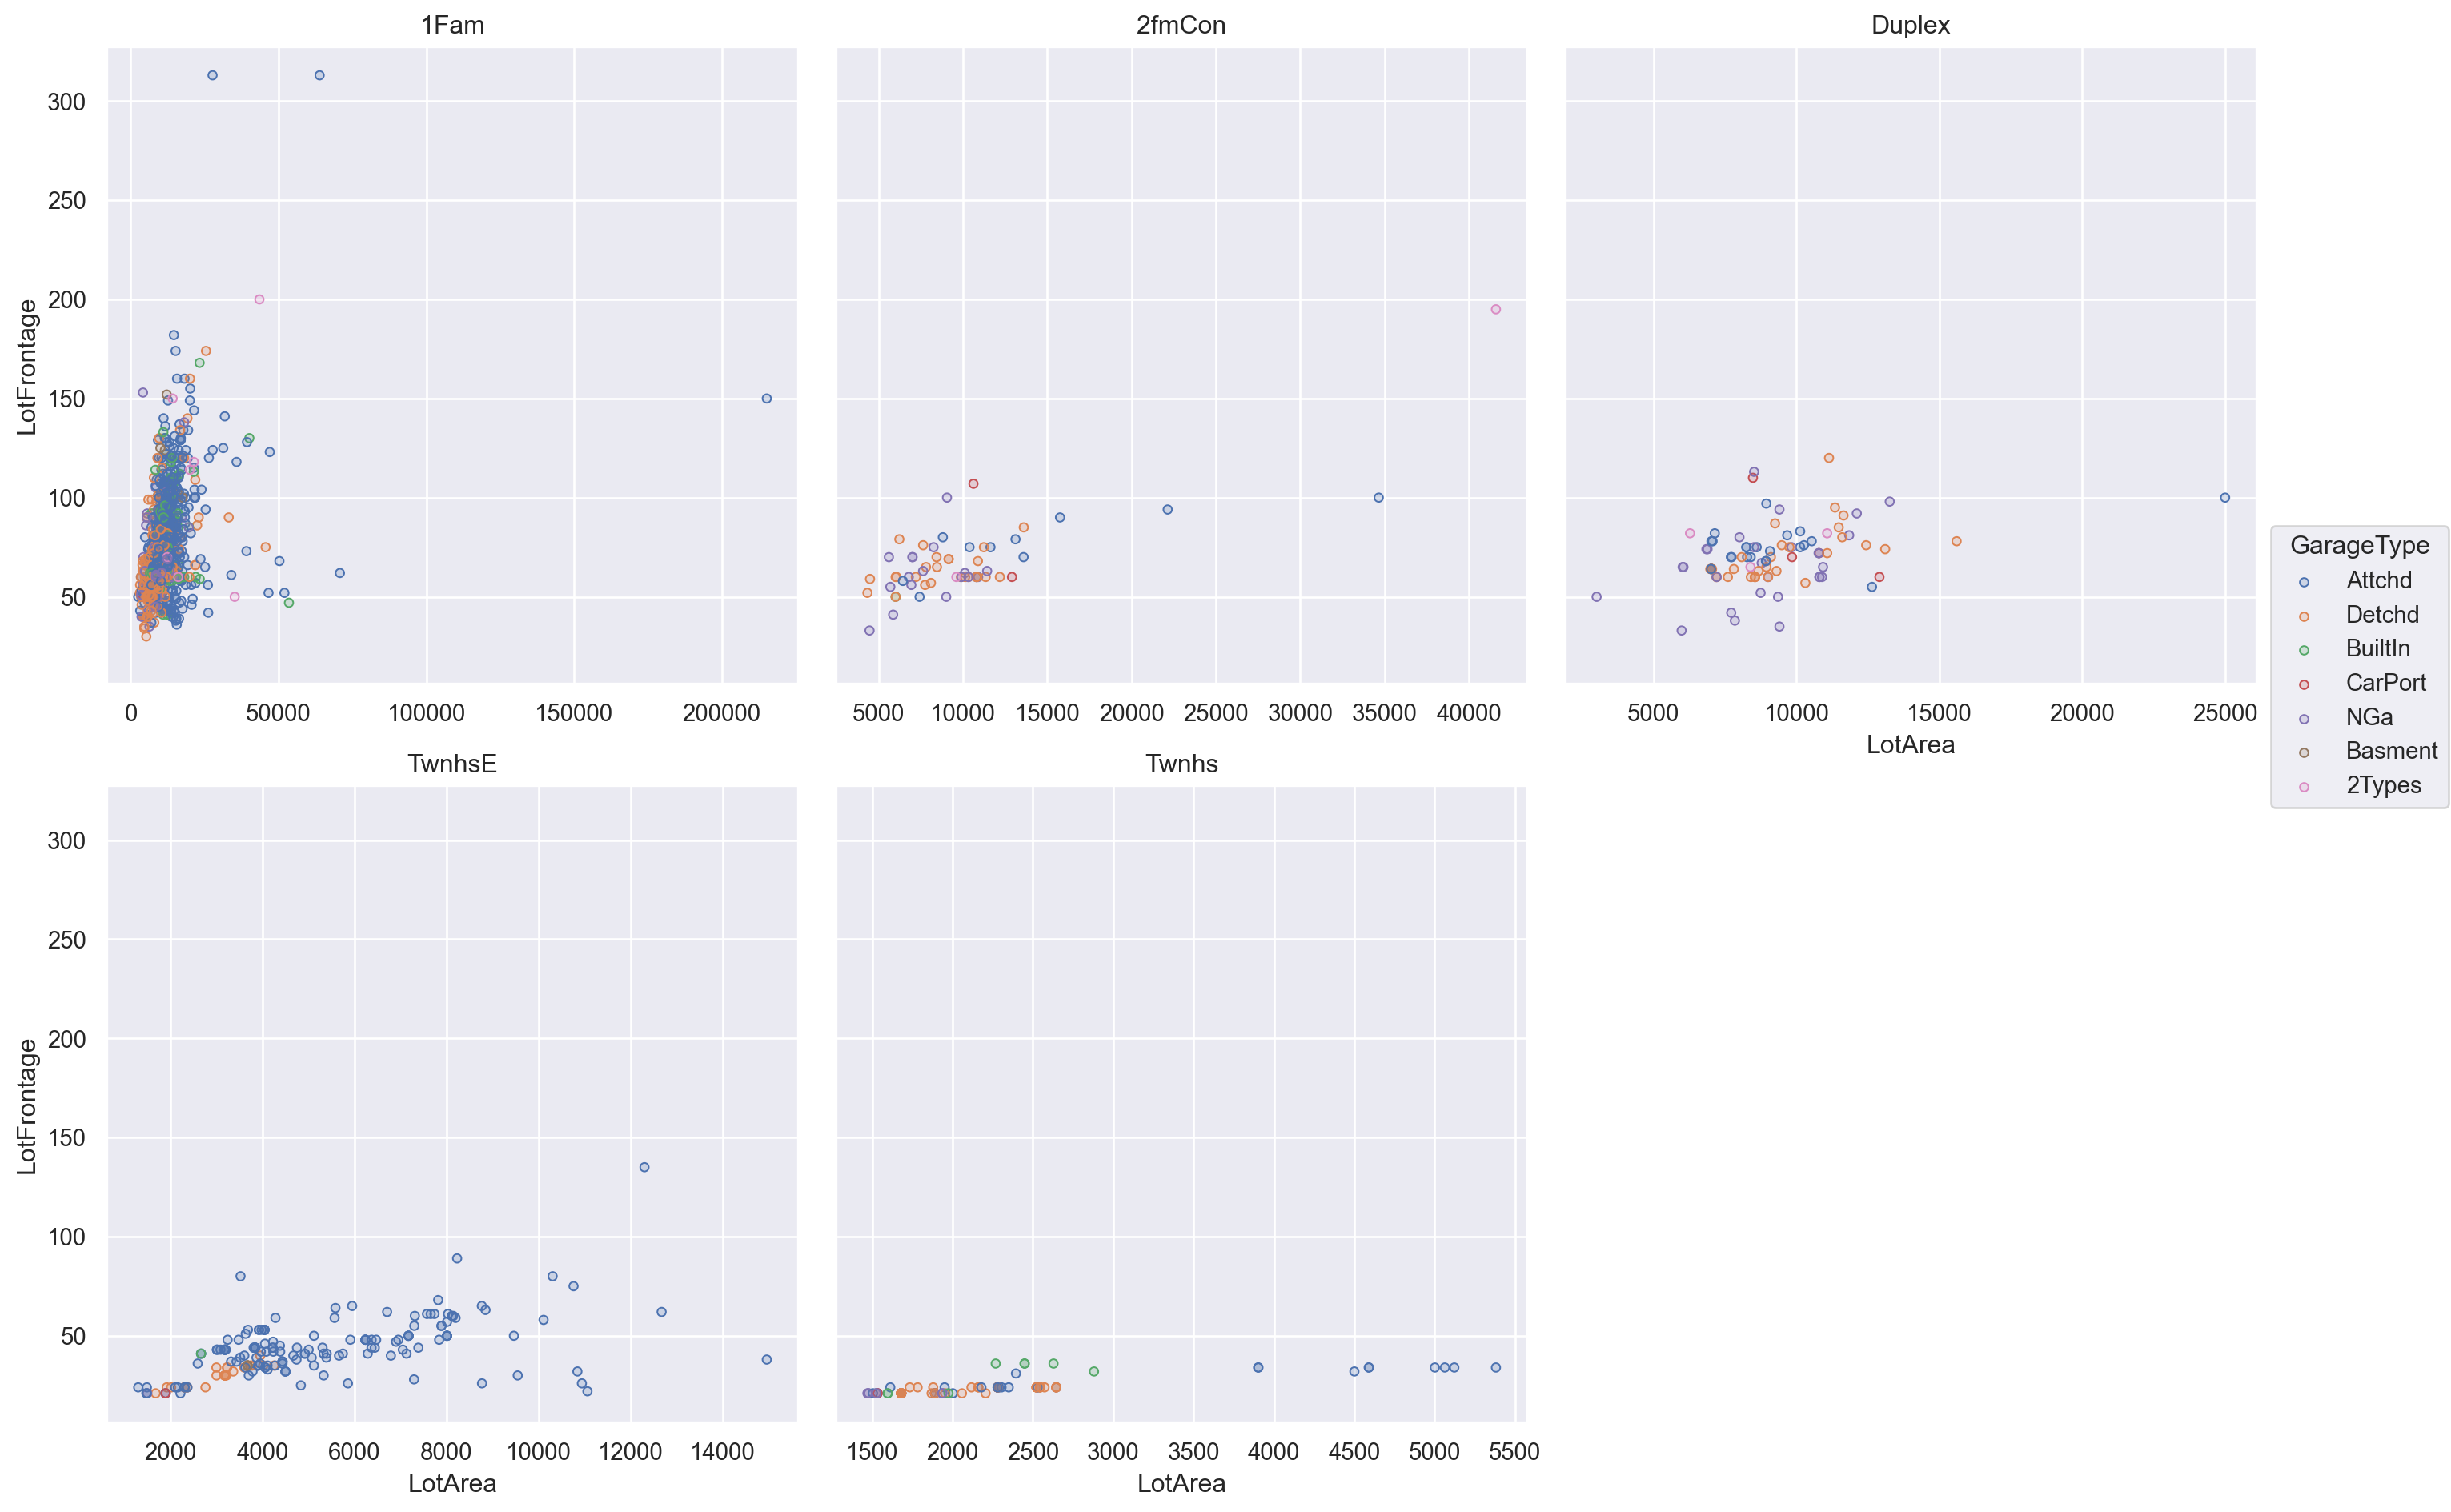

In [67]:
(
    so.Plot(
        merged_df, 
        x='LotArea', y='LotFrontage'
    )
    .facet(col='BldgType', wrap=3)
    .add(so.Dots(), color='GarageType')
    .share(x=False, y=True)
    .layout(size=(15, 10))
)

### Boxplots

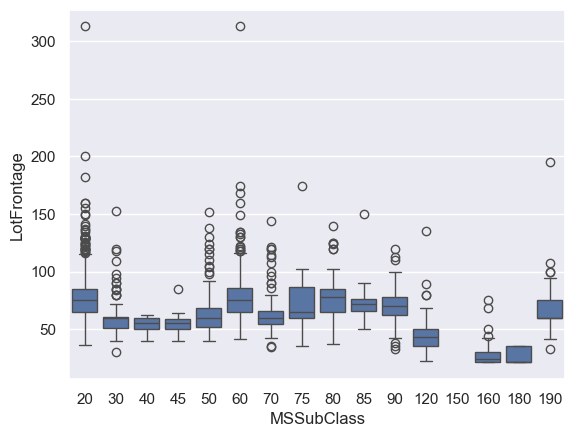

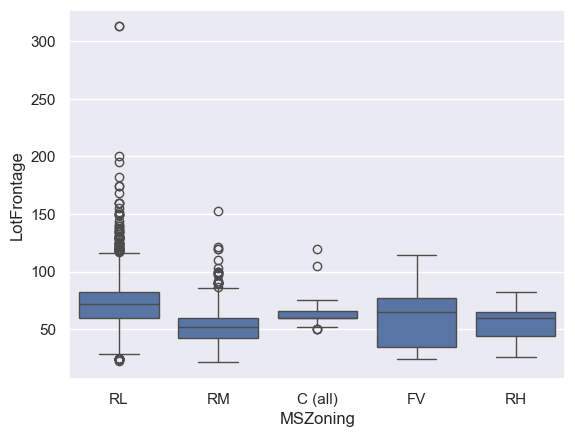

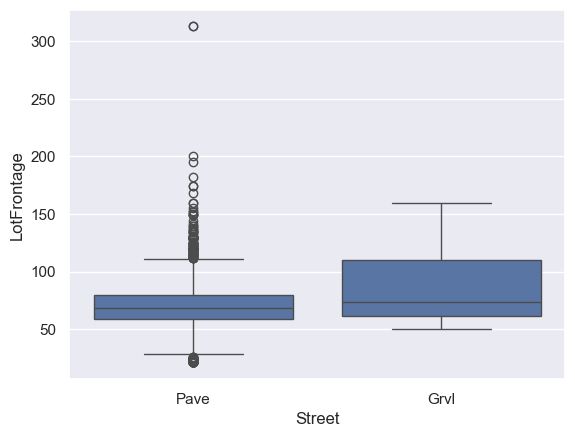

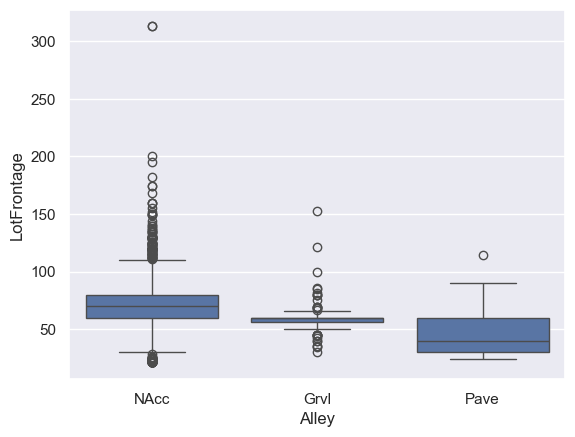

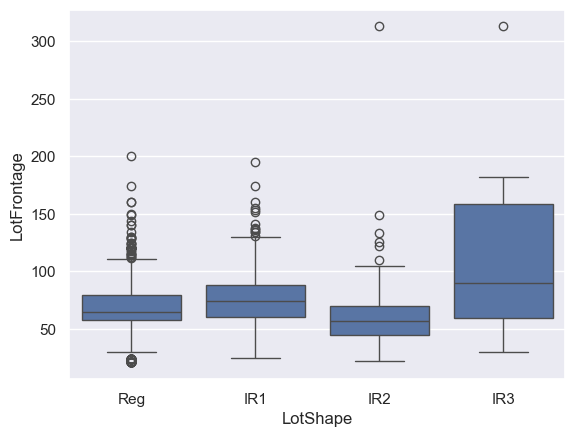

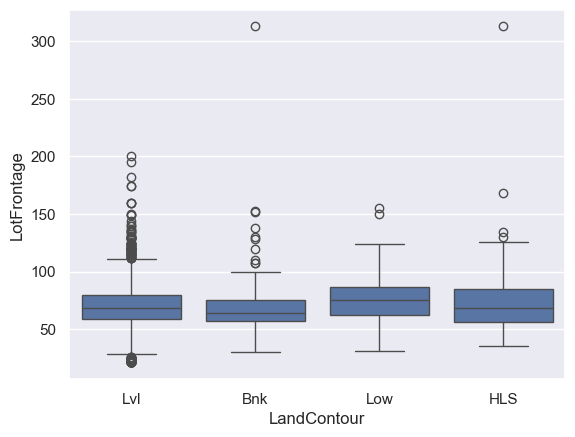

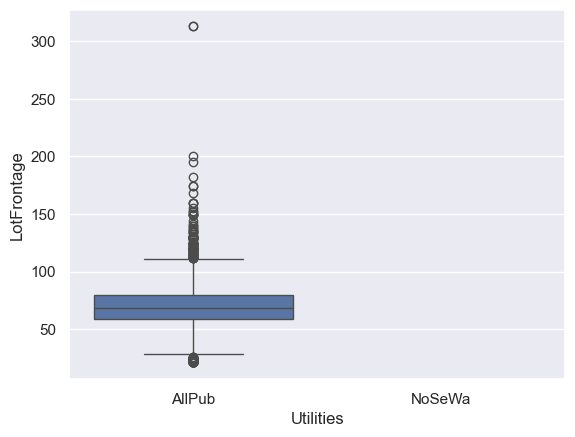

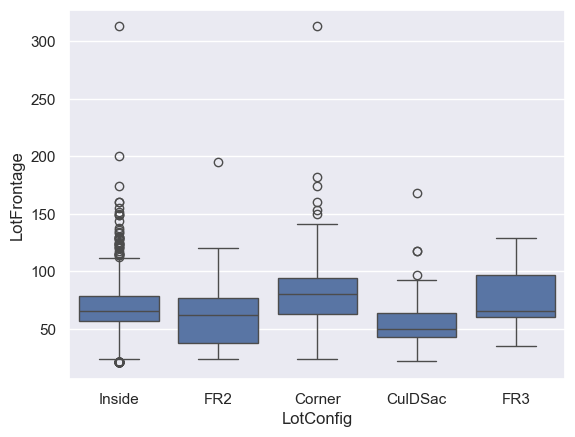

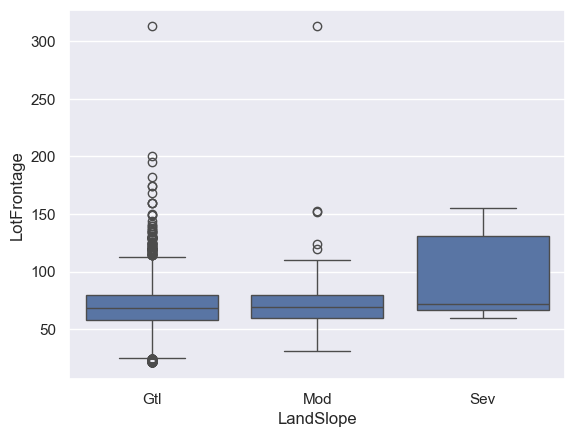

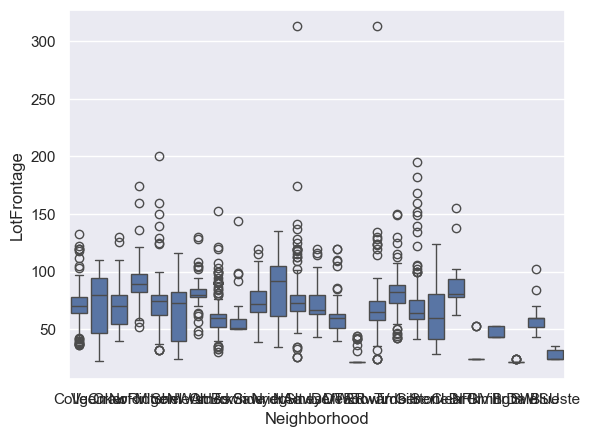

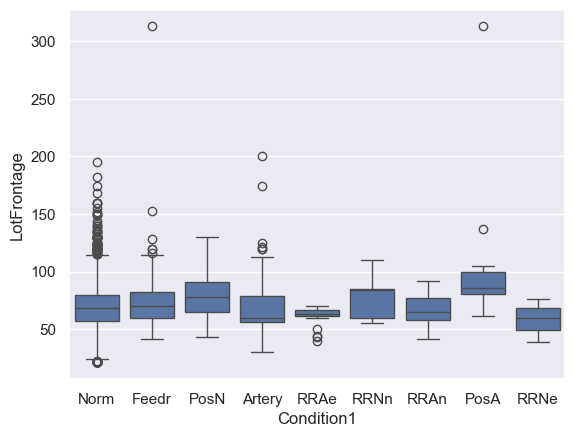

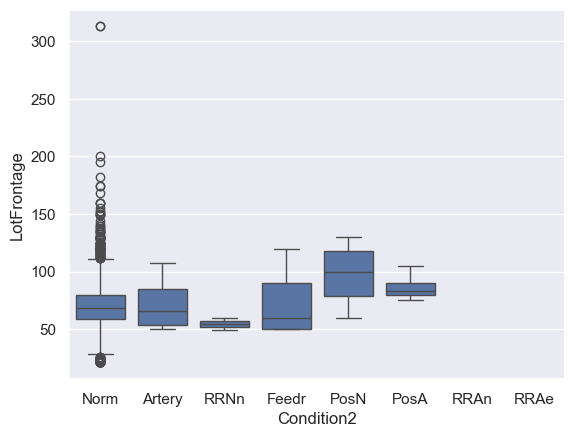

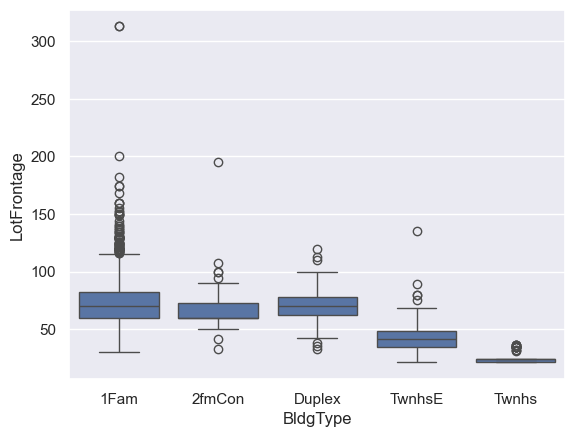

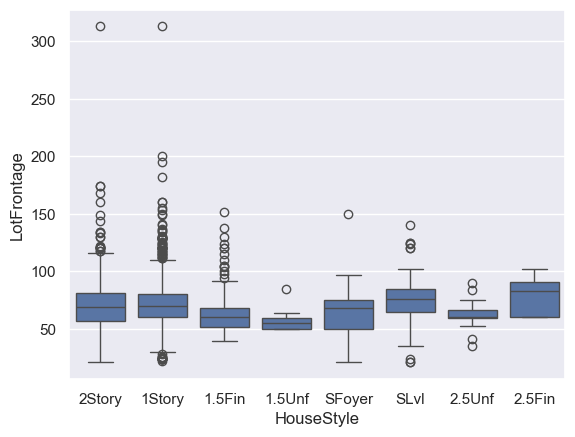

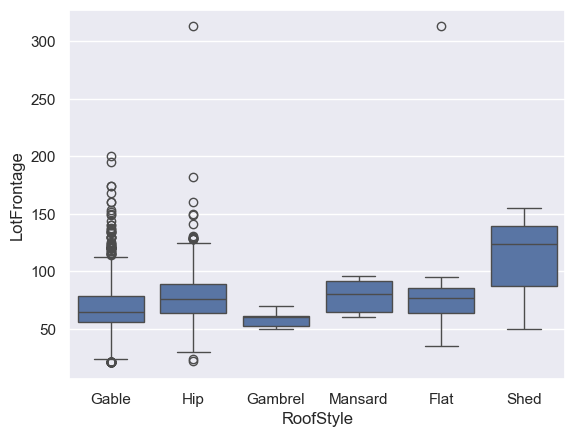

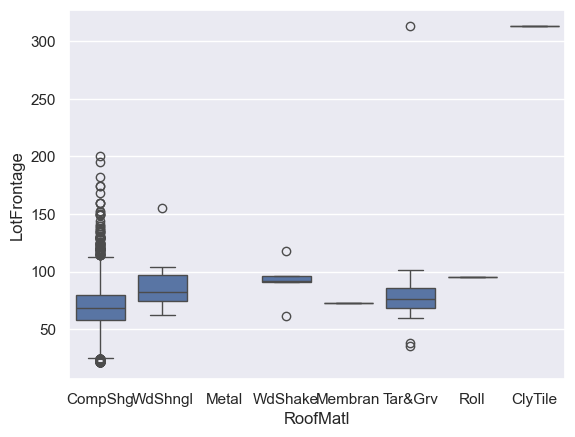

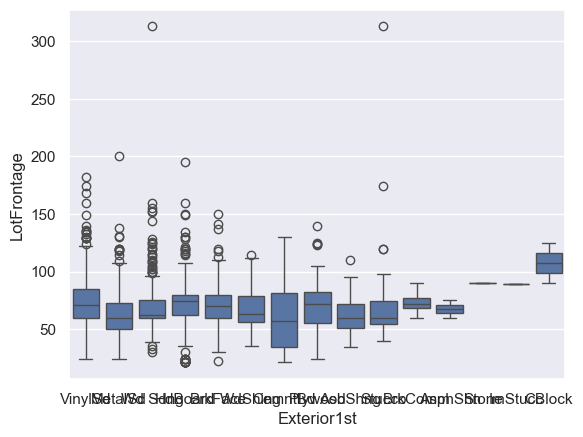

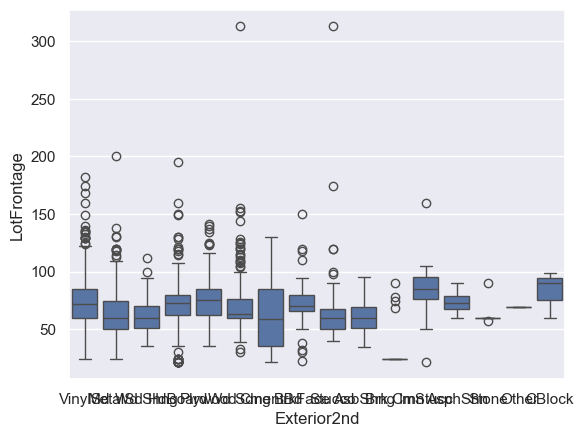

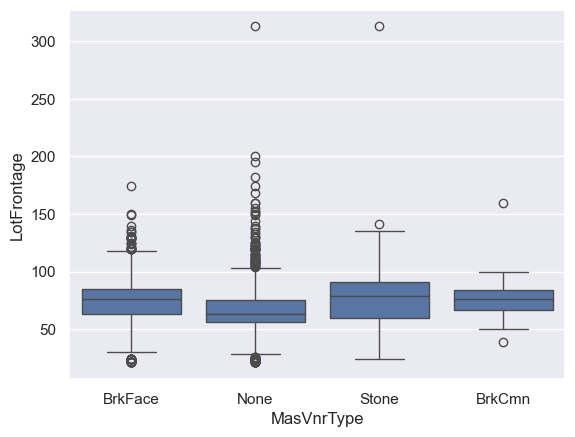

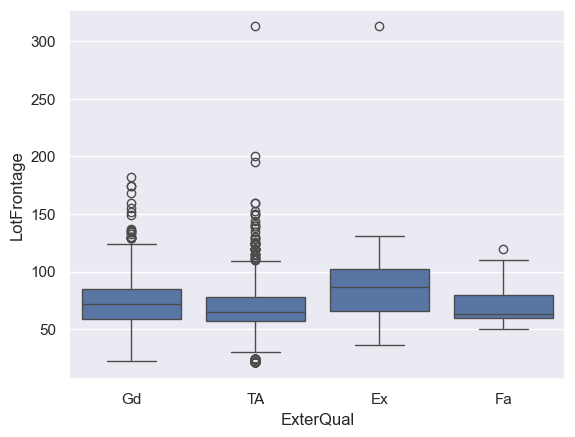

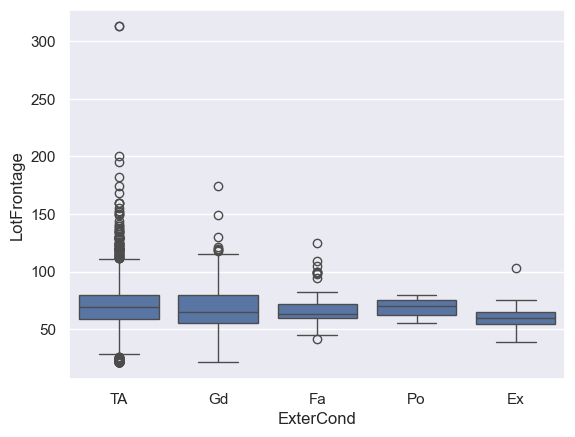

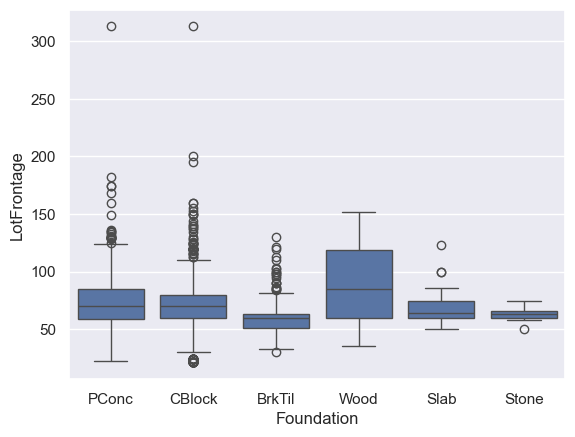

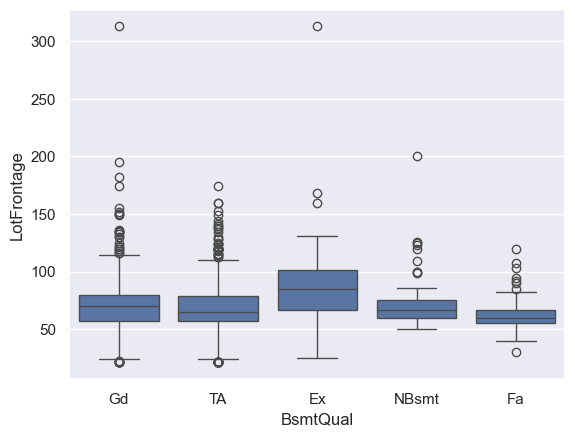

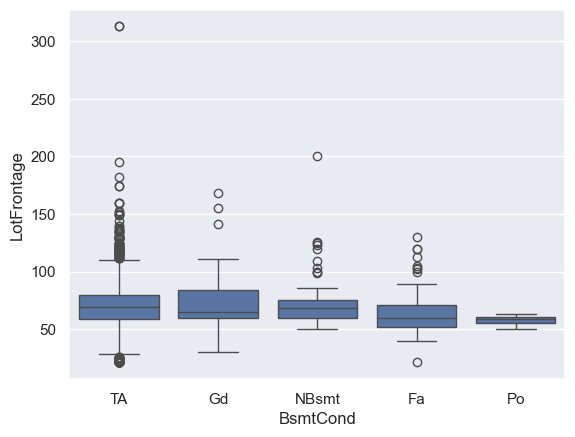

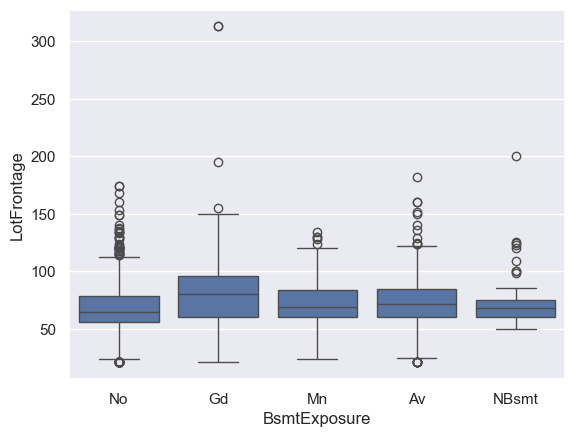

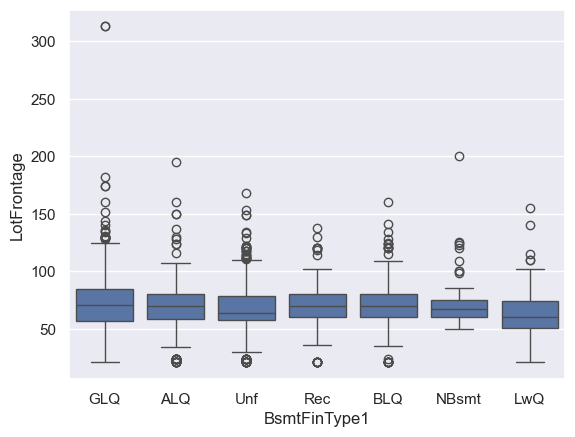

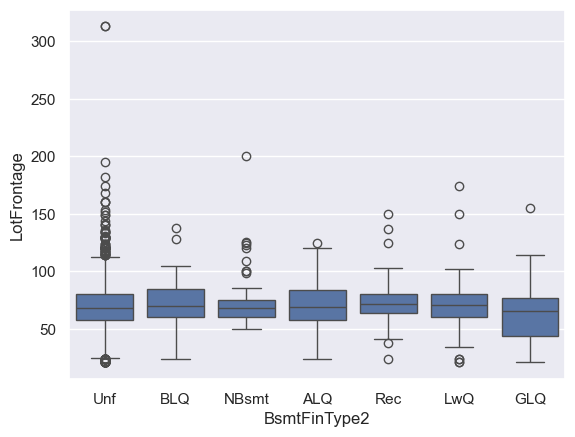

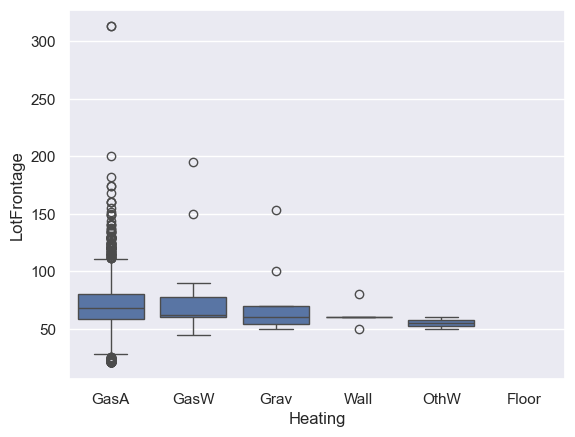

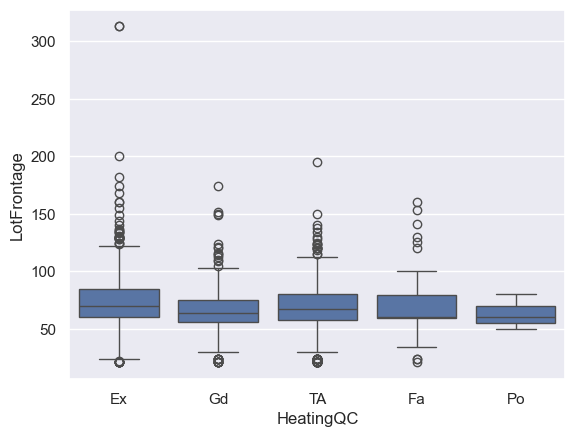

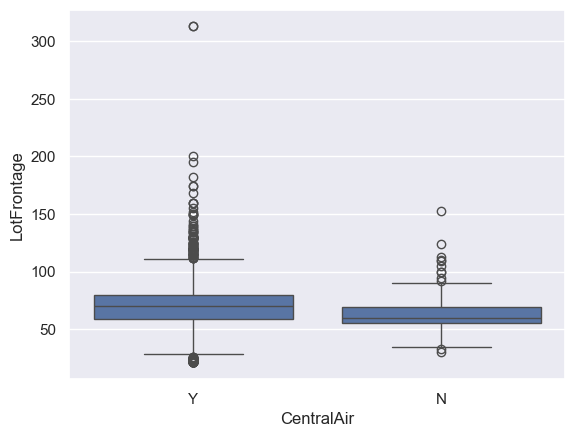

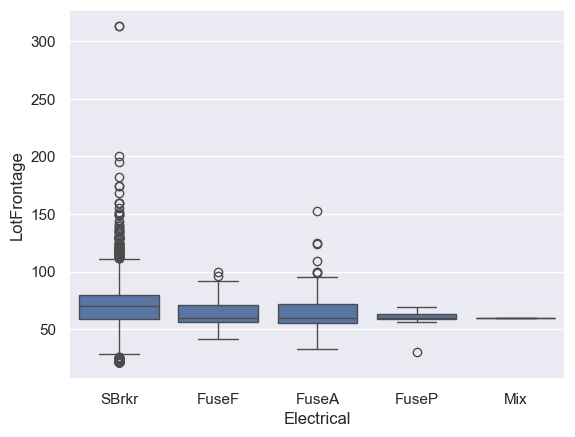

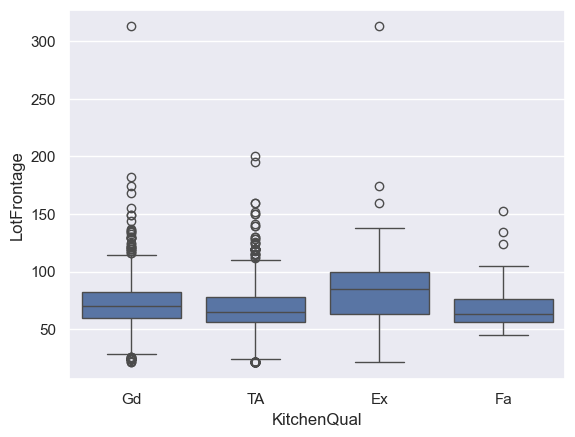

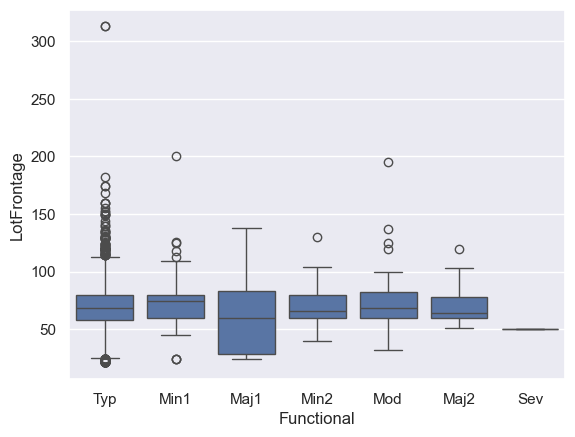

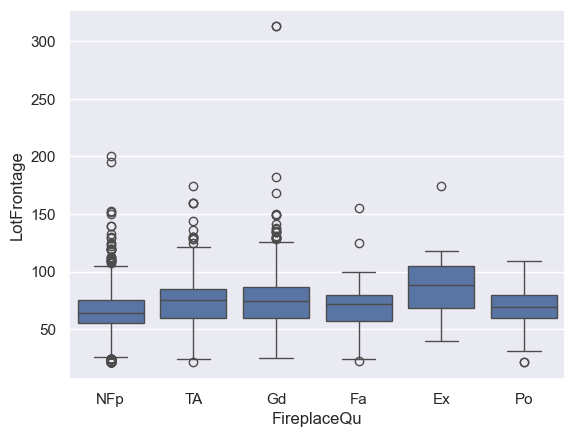

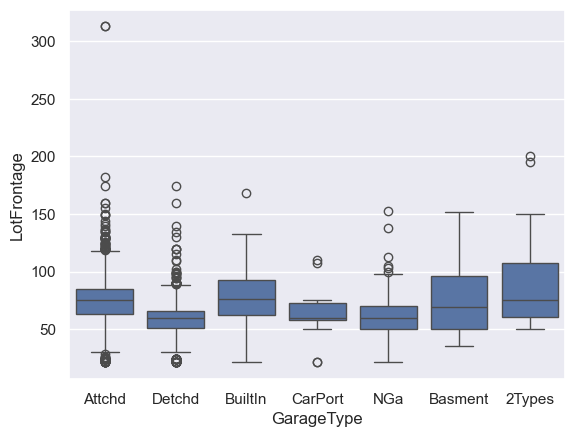

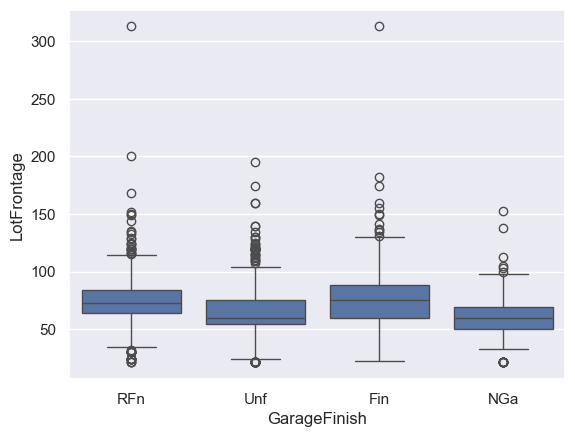

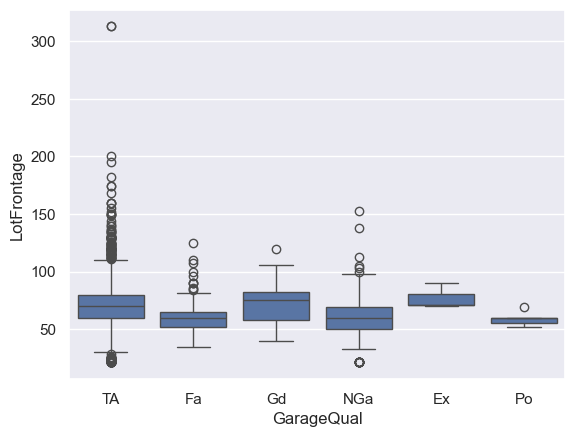

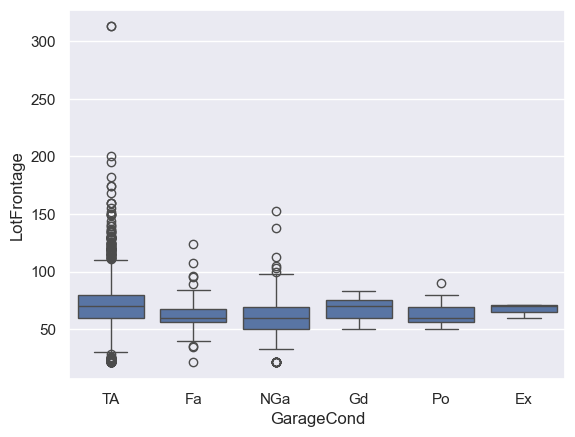

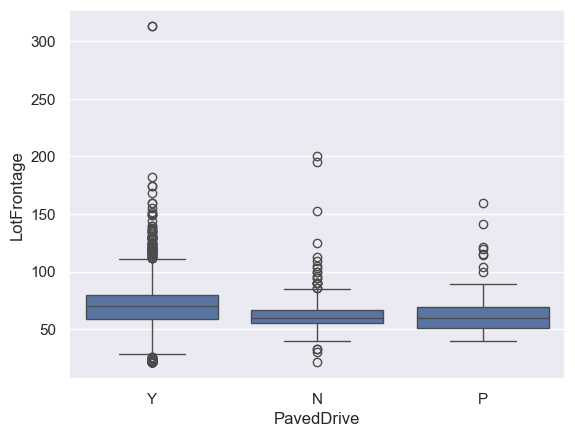

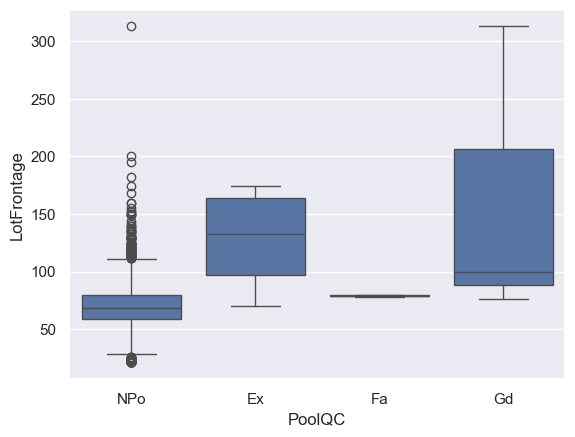

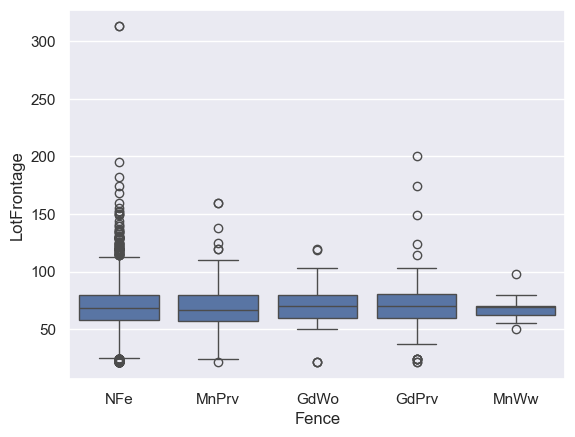

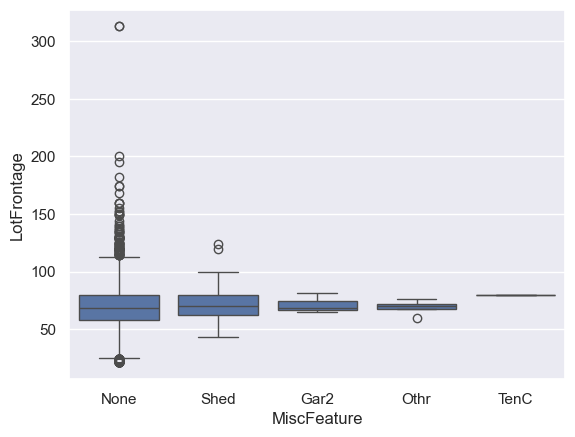

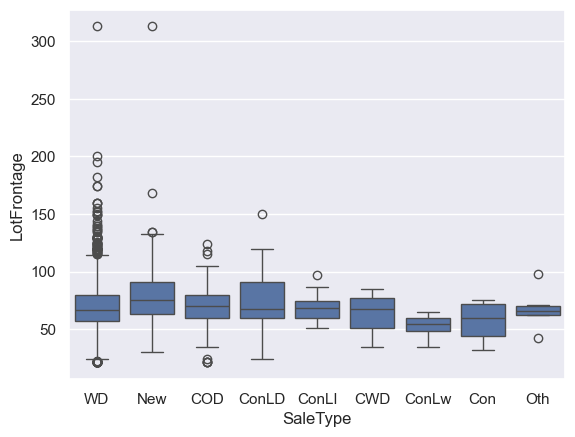

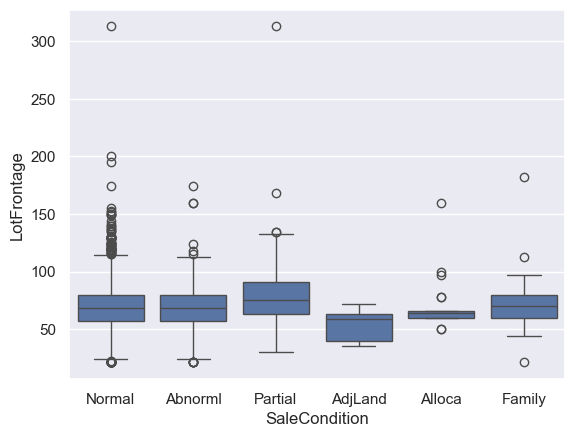

In [68]:
for col in qualitative_df.columns:
    sns.boxplot(data=qualitative_df, x=col, y=merged_df.LotFrontage)
    plt.show()

## Conclusion

Strategy: drop GarageYrBlt and other useless date fragments, LotFrontage by median of itself inside BldgType $\cap$ GarageType or BldgType in case there's no data for the group, MasVnrArea by median of itself inside MasVnrType, MSZoning by mode of itself inside Alley, other numerical by median, and other categorical by mode.

It's possible that this strategy of using the median or mode inside groups of other variables will not work as well as expected. For LotFrontage there are few observations in several groups of the intersection between the two groups.

In [69]:
date_frag_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

In [70]:
# here we define a few partial functions just so it's clearer for the reader
# passing `on` as list to mute numpy's empty slice warnings
impute_lotfrontage = partial(impute_groupby, on=['LotFrontage'])
impute_masvnrarea = partial(impute_groupby, on='MasVnrArea')
impute_mszoning = partial(impute_groupby, on='MSZoning')

In [71]:
merged_filled = (
    merged_df
    .drop(columns=['GarageYrBlt','MoSold','SalePrice'])
    # first we fill with median of intersection of 'BldgType' and 'GarageType'
    .pipe(impute_lotfrontage, with_median, by=['BldgType', 'GarageType'])
    # then we fill remaining with median of 'BldgType'
    .pipe(impute_lotfrontage, with_median, by='BldgType')
    .pipe(impute_masvnrarea, with_median, by='MasVnrType')
    .pipe(impute_mszoning, with_mode, by='Alley')
    .pipe(impute_categorical, with_mode)
    .pipe(impute_numerical, with_median)
    # .pipe(describe_missing)
)
merged_filled.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave  NAcc      Reg   
2          20       RL         80.0     9600   Pave  NAcc      Reg   
3          60       RL         68.0    11250   Pave  NAcc      IR1   
4          70       RL         60.0     9550   Pave  NAcc      IR1   
5          60       RL         84.0    14260   Pave  NAcc      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     1Story            6            8       1976   
3        Norm     1Fam     2Story            7            5       2001   
4        Norm     1Fam     2Story            7            5       1915   
5        Norm     1Fam     2Story            8            5       2000   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           1976     Gable  CompShg     MetalSd     MetalSd       None   
3           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
5           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1        196.0        Gd        TA      PConc       Gd       TA           No   
2          0.0        TA        TA     CBlock       Gd       TA           Gd   
3        162.0        Gd        TA      PConc       Gd       TA           Mn   
4          0.0        TA        TA     BrkTil       TA       Gd           No   
5        350.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ       706.0          Unf         0.0      150.0        856.0   
2           ALQ       978.0          Unf         0.0      284.0       1262.0   
3           GLQ       486.0          Unf         0.0      434.0        920.0   
4           ALQ       216.0          Unf         0.0      540.0        756.0   
5           GLQ       655.0          Unf         0.0      490.0       1145.0   

   Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                                             
1     GasA        Ex          Y      SBrkr       856       854             0   
2     GasA        Ex          Y      SBrkr      1262         0             0   
3     GasA        Ex          Y      SBrkr       920       866             0   
4     GasA        Gd          Y      SBrkr       961       756             0   
5     GasA        Ex          Y      SBrkr      1145      1053             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
Id                                                                            
1        1710           1.0           0.0         2         1             3   
2        1262           0.0           1.0        

# Features

## Adding new numerical features

I'm sure we can do better here. Maybe we could add a few categories. Not sure how to go about that.

In [72]:
merged_featured = (
    merged_filled.assign(
        TotalBaths=lambda df: df.loc[:,['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']].sum(axis=1),
        FullBaths=lambda df: df.loc[:,['BsmtFullBath','FullBath']].sum(axis=1),
        PorchSF=lambda df: df.loc[:, lambda df: df.columns.str.contains('Porch')].sum(axis=1),
        OpenSF=lambda df: df.LotArea-(df.loc[:,['1stFlrSF','PorchSF','WoodDeckSF','PoolArea','GarageArea']].sum(axis=1)),
        TotalArea=lambda df: df.loc[:,['TotalBsmtSF','GrLivArea','GarageArea','WoodDeckSF','PorchSF']].sum(axis=1),
        LivingArea=lambda df: df.TotalBsmtSF+df.GrLivArea,
    )
)

## Scaling

In [73]:
@starassign
def scale(
    df: pd.DataFrame, 
    scaler: Callable[[pd.DataFrame, ...], pd.DataFrame],
    subset: Callable[[pd.DataFrame], pd.DataFrame],
    *args, **kwargs) -> pd.DataFrame:
    """
    Scales each column of the pd.DataFrame returned by `subset`. 
    `subset` is piped into `df`.
    Positional and keyword arguments are passed to `scaler`.
    """
    return scaler(df.pipe(subset), *args, **kwargs)

In [74]:
robust_scale = partial(scale, scaler=ndarray2dataframe(RobustScaler().fit_transform))

In [75]:
numerical_cols = lambda df: df.loc[:,~df.columns.isin(['OverallQual','OverallCond'])].select_dtypes(include='number')

In [76]:
transformed_scaled_df = (
    merged_featured.pipe(log1ptransform, subset=high_positive_skew)
    .pipe(robust_scale, subset=numerical_cols)
)
transformed_scaled_df.head(5)

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
Id                                                                    
1          60       RL    -0.269314 -0.256995   Pave  NAcc      Reg   
2          20       RL     0.485960  0.035356   Pave  NAcc      Reg   
3          60       RL    -0.105377  0.398758   Pave  NAcc      IR1   
4          70       RL    -0.559854  0.023391   Pave  NAcc      IR1   
5          60       RL     0.663727  0.941998   Pave  NAcc      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
Id                                                                     
1          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
3          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
4          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
5          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
Id                                                                       
1        Norm     1Fam     2Story            7            5   0.631579   
2        Norm     1Fam     1Story            6            8   0.063158   
3        Norm     1Fam     2Story            7            5   0.589474   
4        Norm     1Fam     2Story            7            5  -1.221053   
5        Norm     1Fam     2Story            8            5   0.568421   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
Id                                                                       
1       0.256410     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2      -0.435897     Gable  CompShg     MetalSd     MetalSd       None   
3       0.230769     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4      -0.589744     Gable  CompShg     Wd Sdng     Wd Shng       None   
5       0.179487     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
Id                                                                             
1     1.035332        Gd        TA      PConc       Gd       TA           No   
2     0.000000        TA        TA     CBlock       Gd       TA           Gd   
3     0.998206        Gd        TA      PConc       Gd       TA           Mn   
4     0.000000        TA        TA     BrkTil       TA       Gd           No   
5     1.148519        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
Id                                                                             
1           GLQ    0.098337          Unf         0.0  -0.874234    -0.292267   
2           ALQ    0.147667          Unf         0.0  -0.383315     0.490642   
3           GLQ    0.041845          Unf         0.0  -0.056512    -0.146868   
4           ALQ   -0.080663          Unf         0.0   0.112025    -0.542750   
5           GLQ    0.086991          Unf         0.0   0.037078     0.294389   

   Heating HeatingQC  ...  2ndFlrSF LowQualFinSF  GrLivArea  BsmtFullBath  \
Id                    ...                                                   
1     GasA        Ex  ...  1.029414          0.0   0.386737           1.0   
2     GasA        Ex  ...  0.000000          0.0  -0.308118           0.0   
3     GasA        Ex  ...  1.031539          0.0   0.486209           1.0   
4     GasA        Gd  ...  1.010851          0.0   0.396082           1.0   
5     GasA        Ex  ...  1.061320          0.0   0.961055           1.0   

    BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
Id                                                                              
1       0.000000       0.0       1.0           0.0           0.0           Gd   
2       0.693147       0.0       0.0           0.0       

## Label encode and preserve order

In [77]:
import json

In [78]:
with open('../datasets/ordinal_column_mapping.json') as f:
    ordinal_column_mapping = json.load(f)

In [79]:
ordinal_column_mapping

{'Street': {'Pave': '1', 'Grvl': '0'},
 'Alley': {'NAcc': '0', 'Pave': '2', 'Grvl': '1'},
 'LotShape': {'IR3': '0', 'IR2': '1', 'IR1': '2', 'Reg': '3'},
 'LandContour': {'Low': '0', 'HLS': '1', 'Bnk': '2', 'Lvl': '3'},
 'Utilities': {'ELO': '0', 'NoSeWa': '1', 'NoSewr': '2', 'AllPub': '3'},
 'LandSlope': {'Sev': '0', 'Mod': '1', 'Gtl': '2'},
 'ExterQual': {'Po': '0', 'Fa': '1', 'TA': '2', 'Gd': '3', 'Ex': '4'},
 'ExterCond': {'Po': '0', 'Fa': '1', 'TA': '2', 'Gd': '3', 'Ex': '4'},
 'BsmtQual': {'NBsmt': '0',
  'Po': '1',
  'Fa': '2',
  'TA': '3',
  'Gd': '4',
  'Ex': '5'},
 'BsmtCond': {'NBsmt': '0',
  'Po': '1',
  'Fa': '2',
  'TA': '3',
  'Gd': '4',
  'Ex': '5'},
 'BsmtExposure': {'NBsmt': '0', 'No': '1', 'Mn': '2', 'Av': '3', 'Gd': '4'},
 'BsmtFinType1': {'NBsmt': '0',
  'Unf': '1',
  'LwQ': '2',
  'Rec': '3',
  'BLQ': '4',
  'ALQ': '5',
  'GLQ': '6'},
 'BsmtFinType2': {'NBsmt': '0',
  'Unf': '1',
  'LwQ': '2',
  'Rec': '3',
  'BLQ': '4',
  'ALQ': '5',
  'GLQ': '6'},
 'HeatingQC': {

## Conclusion

In [80]:
(
    transformed_scaled_df
    .replace(ordinal_column_mapping)
    .astype({k:'int64' for k in ordinal_column_mapping.keys()})
    .pipe(pd.get_dummies)
)

LotFrontage   LotArea  Street  Alley  LotShape  LandContour  Utilities  \
Id                                                                             
1       -0.269314 -0.256995       1      0         3            3          3   
2        0.485960  0.035356       1      0         3            3          3   
3       -0.105377  0.398758       1      0         2            3          3   
4       -0.559854  0.023391       1      0         2            3          3   
5        0.663727  0.941998       1      0         2            3          3   
...           ...       ...     ...    ...       ...          ...        ...   
2915    -4.320949 -3.632648       1      0         3            3          3   
2916    -4.320949 -3.682880       1      0         3            3          3   
2917     3.019421  1.717094       1      0         3            3          3   
2918    -0.440877  0.227767       1      0         3            3          3   
2919     0.202130  0.041791       1      0         3            3          3   

      LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                   
1             2            7            5   0.631579      0.256410   
2             2            6            8   0.063158     -0.435897   
3             2            7            5   0.589474      0.230769   
4             2            7            5  -1.221053     -0.589744   
5             2            8            5   0.568421      0.179487   
...         ...          ...          ...        ...           ...   
2915          2            4            7  -0.063158     -0.589744   
2916          2            4            5  -0.063158     -0.589744   
2917          2            5            7  -0.273684      0.076923   
2918          2            5            5   0.400000     -0.025641   
2919          1            7            5   0.421053      0.025641   

      MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  \
Id                                                                         
1       1.035332          3          2         4         3             1   
2       0.000000          2          2         4         3             4   
3       0.998206          3          2         4         3             2   
4       0.000000          2          2         3         4             1   
5       1.148519          3          2         4         3             3   
...          ...        ...        ...       ...       ...           ...   
2915    0.000000          2          2         3         3             1   
2916    0.000000          2          2         3         3             1   
2917    0.000000          2          2         3         3             1   
2918    0.000000          2          2         4         3             3   
2919    0.892409          2          2         4         3             3   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
Id                                                                    
1                6    0.098337             1         0.0  -0.874234   
2                5    0.147667             1         0.0  -0.383315   
3                6    0.041845             1         0.0  -0.056512   
4                5   -0.080663             1         0.0   0.112025   
5                6    0.086991             1         0.0   0.037078   
...            ...         ...           ...         ...        ...   
2915             1   -0.895983             1         0.0   0.120549   
2916             3   -0.057401             1         0.0  -0.356663   
2917             5    0.181639             1         0.0  -4.751814   
2918             6   -0.013504             1         0.0   0.160473   
2919             2    0.109093             1         0.0  -0.519356   

      TotalBsmtSF  HeatingQC  Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
Id                                                             